# TESS Atlas fit for TOI 190

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 190.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-190.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-190.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-190.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 190

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 190 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

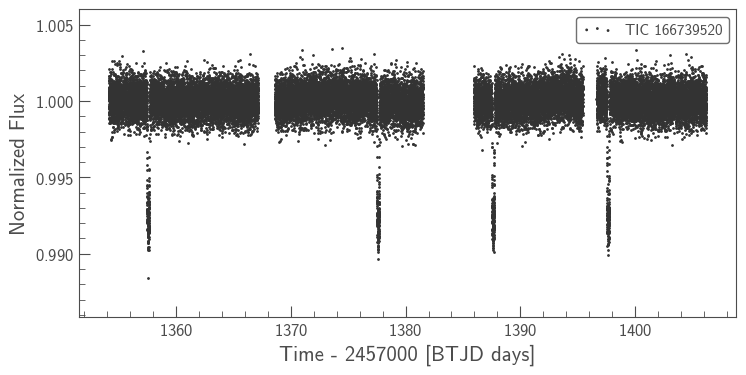

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -53547.400416534896 -> -53506.99029738201


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -42634.07139691589 -> -39753.204731292855


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -39753.204731292855 -> -38248.8796938841


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -38248.8796938841 -> -38242.653609739435


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -38242.653609739435 -> -38242.51387918714


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -38242.51387918714 -> -38242.07932787705


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -38242.07932787705 -> -38098.86847857254


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -38098.86847857254 -> -38098.86847857208


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -38098.86847857209 -> -38098.86847857209


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -38098.86847857209 -> -38098.86847857205


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -38098.86847857205 -> -38098.86847857205


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -38098.86847857205 -> -38098.86847857205


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -38098.86847857205 -> -38098.86847857205


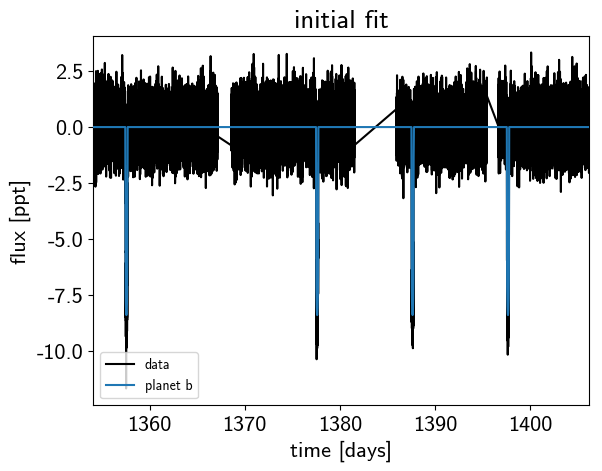

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:09,  9.87draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:17,  5.15draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:30,  3.01draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:35,  2.54draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:03<00:39,  2.23draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:42,  2.08draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:04<00:45,  1.92draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:05<00:45,  1.90draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:05<00:51,  1.64draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:06<00:50,  1.68draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:06<00:47,  1.76draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:07<00:50,  1.63draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:07<00:42,  1.92draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:08<00:45,  1.75draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:08<00:38,  2.03draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:09<00:43,  1.77draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:09<00:36,  2.09draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:10<00:43,  1.73draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:11<00:37,  2.00draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:11<00:45,  1.62draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:12<00:34,  2.09draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:13<00:45,  1.59draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:14<00:42,  1.66draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:14<00:31,  2.20draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:15<00:42,  1.62draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:15<00:31,  2.13draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:16<00:43,  1.51draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:17<00:35,  1.76draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:18<00:33,  1.82draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:18<00:25,  2.32draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:19<00:32,  1.81draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:19<00:29,  1.94draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:20<00:30,  1.85draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:21<00:28,  1.94draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:21<00:30,  1.83draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:22<00:28,  1.87draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:22<00:29,  1.77draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:23<00:29,  1.77draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:24<00:33,  1.54draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:24<00:29,  1.70draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:25<00:36,  1.35draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:25<00:26,  1.79draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:26<00:31,  1.49draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:26<00:23,  1.93draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:27<00:27,  1.61draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:28<00:21,  2.04draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:28<00:25,  1.69draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:29<00:20,  2.05draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:29<00:23,  1.77draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:30<00:18,  2.11draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:30<00:23,  1.66draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:32<00:21,  1.72draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:33<00:19,  1.76draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:34<00:18,  1.80draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:34<00:13,  2.36draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:35<00:20,  1.53draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:36<00:18,  1.60draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:36<00:14,  1.95draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:38<00:19,  1.41draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:39<00:16,  1.54draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:40<00:14,  1.59draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:40<00:10,  2.11draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:41<00:13,  1.61draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:41<00:11,  1.73draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:42<00:11,  1.71draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:42<00:10,  1.72draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:43<00:10,  1.66draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:44<00:09,  1.76draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:45<00:10,  1.45draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:45<00:08,  1.63draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:46<00:09,  1.40draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:46<00:06,  1.87draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:47<00:07,  1.54draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:47<00:05,  1.93draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:48<00:05,  1.68draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:48<00:04,  1.86draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:49<00:03,  1.77draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:49<00:03,  1.97draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:50<00:02,  1.81draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:51<00:02,  1.85draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:52<00:02,  1.22draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:53<00:01,  1.02draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:54<00:00,  1.03draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:57<00:00,  1.61s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:09,  9.50draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:12,  7.52draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:31,  2.87draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:36,  2.49draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:03<00:38,  2.28draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:04<00:47,  1.85draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:04<00:41,  2.09draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:05<00:45,  1.88draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:05<00:41,  2.02draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:05<00:43,  1.94draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:06<00:42,  1.96draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:06<00:41,  2.00draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:07<00:42,  1.92draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:08<00:34,  2.27draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:08<00:35,  2.18draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:08<00:34,  2.25draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:09<00:29,  2.53draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:09<00:28,  2.55draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:10<00:32,  2.23draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:10<00:30,  2.35draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:11<00:32,  2.16draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:11<00:30,  2.26draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:12<00:33,  2.04draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:12<00:32,  2.12draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:13<00:26,  2.45draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:13<00:27,  2.37draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:14<00:27,  2.31draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:14<00:28,  2.23draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:15<00:28,  2.21draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:15<00:28,  2.12draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:16<00:26,  2.24draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:16<00:31,  1.89draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:17<00:25,  2.27draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:17<00:24,  2.26draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:18<00:19,  2.88draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:19<00:28,  1.90draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:19<00:21,  2.45draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:20<00:21,  2.33draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:20<00:16,  2.97draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:21<00:23,  2.04draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:22<00:20,  2.25draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:23<00:19,  2.20draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:23<00:14,  2.98draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:24<00:21,  1.90draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:24<00:16,  2.45draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:25<00:21,  1.80draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:25<00:16,  2.31draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:26<00:20,  1.77draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:27<00:19,  1.83draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:28<00:18,  1.80draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:29<00:17,  1.78draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:29<00:13,  2.26draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:30<00:12,  2.17draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:30<00:09,  2.77draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:31<00:12,  2.01draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:31<00:10,  2.47draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:32<00:12,  1.89draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:32<00:08,  2.56draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:33<00:07,  2.54draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:33<00:06,  2.93draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:34<00:08,  2.25draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:34<00:06,  2.61draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:35<00:07,  2.12draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:35<00:06,  2.35draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:36<00:07,  1.96draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:36<00:05,  2.18draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:37<00:05,  2.14draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:38<00:04,  2.10draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:39<00:03,  2.27draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:39<00:03,  1.94draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:40<00:03,  1.94draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:40<00:02,  1.99draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:41<00:02,  1.62draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:41<00:00,  2.21draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:46<00:01,  1.69s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [00:46<00:00,  1.29s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:01<03:47,  1.12s/draws]

Sampling 2 chains:   1%|          | 2/204 [00:01<02:47,  1.21draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:01<02:03,  1.62draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:02<02:17,  1.46draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:02<01:55,  1.73draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:03<01:57,  1.69draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:03<01:46,  1.86draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:04<01:45,  1.85draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:04<01:45,  1.86draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:05<01:32,  2.09draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:05<01:25,  2.26draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:05<01:13,  2.59draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:06<01:30,  2.09draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:07<01:23,  2.25draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:07<01:11,  2.63draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:07<00:55,  3.32draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:08<01:23,  2.20draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:08<01:09,  2.62draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:09<01:36,  1.89draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:09<01:15,  2.40draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:10<01:17,  2.33draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:10<01:05,  2.75draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:10<00:52,  3.40draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:11<01:14,  2.36draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:11<01:05,  2.68draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:12<00:57,  3.04draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:12<01:11,  2.43draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:13<01:01,  2.78draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:14<01:24,  2.00draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:14<01:15,  2.24draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:14<00:57,  2.89draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:15<01:02,  2.62draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:15<00:53,  3.04draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:16<01:00,  2.69draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:16<01:09,  2.33draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:17<01:02,  2.54draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:18<01:17,  2.04draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:18<01:05,  2.41draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:18<01:01,  2.57draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:19<01:05,  2.37draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:19<00:53,  2.88draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:19<00:43,  3.55draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:19<00:35,  4.28draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:20<00:40,  3.73draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:20<00:40,  3.66draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:20<00:40,  3.67draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:21<00:53,  2.75draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:21<00:43,  3.33draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:22<00:52,  2.73draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:22<00:58,  2.46draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:23<00:57,  2.49draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:23<00:48,  2.94draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:24<00:56,  2.47draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:24<01:02,  2.21draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:25<01:06,  2.07draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:25<01:08,  1.99draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:25<00:53,  2.54draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:26<00:46,  2.85draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:26<00:52,  2.54draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:27<00:51,  2.57draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:27<00:39,  3.32draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:27<00:35,  3.61draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:28<00:30,  4.19draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:28<00:31,  4.03draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:29<00:44,  2.82draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:29<00:35,  3.46draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:29<00:33,  3.58draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:30<00:43,  2.75draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:30<00:37,  3.21draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:30<00:43,  2.73draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:31<00:42,  2.78draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:32<01:05,  1.77draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:32<00:48,  2.37draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:32<00:49,  2.30draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:33<00:57,  1.95draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:33<00:47,  2.32draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:34<00:46,  2.37draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:34<00:38,  2.84draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:34<00:32,  3.36draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:34<00:26,  4.06draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:35<00:27,  3.86draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:35<00:33,  3.11draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:35<00:31,  3.30draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:36<00:42,  2.41draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:37<00:42,  2.37draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:37<00:47,  2.10draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:38<00:49,  1.99draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:39<00:42,  2.27draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:39<00:32,  2.87draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:39<00:25,  3.66draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:40<00:43,  2.11draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:40<00:34,  2.63draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:41<00:38,  2.30draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:41<00:37,  2.37draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:42<00:30,  2.81draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:42<00:36,  2.38draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:42<00:30,  2.77draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:43<00:32,  2.57draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:44<00:27,  2.95draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:44<00:24,  3.31draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:44<00:22,  3.62draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:44<00:24,  3.28draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:45<00:23,  3.32draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:45<00:19,  3.90draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:45<00:18,  4.05draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:45<00:18,  3.97draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:45<00:14,  5.12draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:46<00:18,  3.90draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:47<00:30,  2.30draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:47<00:25,  2.73draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:48<00:36,  1.89draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:48<00:28,  2.37draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:49<00:39,  1.70draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:49<00:30,  2.18draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:50<00:31,  2.06draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:50<00:27,  2.33draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:51<00:27,  2.25draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:51<00:21,  2.85draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:51<00:18,  3.20draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:52<00:24,  2.37draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:52<00:19,  2.97draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:53<00:30,  1.88draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:53<00:26,  2.08draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:54<00:26,  2.07draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:54<00:23,  2.35draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:55<00:27,  1.93draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:56<00:26,  1.91draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:56<00:21,  2.26draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:57<00:21,  2.24draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:58<00:25,  1.87draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:58<00:20,  2.19draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:59<00:22,  1.99draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:59<00:17,  2.40draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:59<00:14,  2.81draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:00<00:21,  1.89draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [01:00<00:16,  2.50draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [01:01<00:20,  1.93draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [01:01<00:15,  2.43draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [01:02<00:22,  1.67draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [01:02<00:16,  2.16draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [01:03<00:11,  2.85draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [01:03<00:09,  3.31draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:04<00:13,  2.30draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [01:04<00:12,  2.50draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [01:04<00:10,  2.90draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [01:05<00:13,  2.10draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [01:05<00:11,  2.52draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:06<00:10,  2.39draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [01:06<00:08,  3.09draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [01:06<00:06,  3.82draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:06<00:05,  4.58draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [01:07<00:10,  2.15draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [01:08<00:08,  2.53draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [01:08<00:10,  1.94draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:09<00:08,  2.11draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [01:09<00:07,  2.29draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [01:10<00:07,  2.42draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [01:10<00:05,  2.97draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [01:10<00:04,  3.10draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [01:11<00:06,  2.27draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:11<00:04,  2.70draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [01:12<00:04,  2.59draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:12<00:03,  2.59draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:12<00:02,  2.84draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:13<00:02,  3.13draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:13<00:02,  2.47draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:14<00:02,  1.81draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:15<00:02,  1.40draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:16<00:01,  1.54draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:16<00:00,  2.04draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:19<00:00,  1.06s/draws]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:13, 29.99draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:15, 26.22draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:21, 18.68draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:23, 16.93draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:00<00:27, 14.51draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:00<00:23, 16.73draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:00<00:20, 18.71draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:01<00:21, 17.51draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:01<00:25, 15.27draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:01<00:24, 15.60draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:01<00:23, 15.89draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:01<00:29, 12.57draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:02<00:33, 11.10draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:02<00:38,  9.54draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:02<00:49,  7.51draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:02<00:46,  7.84draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:03<00:46,  7.88draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:03<00:40,  9.01draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:03<00:39,  9.22draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:03<00:34, 10.49draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:03<00:28, 12.41draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:03<00:31, 11.41draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:04<00:36,  9.75draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:04<00:33, 10.57draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:04<00:30, 11.53draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:04<00:48,  7.20draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:05<00:41,  8.28draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:05<00:42,  8.12draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:05<00:36,  9.38draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:05<00:36,  9.40draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:06<00:39,  8.51draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:06<00:41,  8.16draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:06<00:41,  8.01draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:06<00:54,  6.09draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:06<00:51,  6.50draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:06<00:41,  7.95draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:07<00:41,  7.93draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:07<00:35,  9.07draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:07<00:33,  9.67draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:07<00:31, 10.03draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:08<00:28, 11.12draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:08<00:31, 10.08draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:08<00:30, 10.30draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:08<00:26, 11.76draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:08<00:23, 13.16draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:08<00:21, 14.12draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:09<00:32,  9.48draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:09<00:28, 10.72draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:09<00:29, 10.34draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:09<00:27, 10.99draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:09<00:26, 11.18draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:10<00:31,  9.30draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:10<00:38,  7.68draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:10<00:35,  8.14draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:10<00:33,  8.64draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:11<00:33,  8.63draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:11<00:28, 10.00draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:11<00:25, 11.18draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:11<00:28,  9.84draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:11<00:25, 11.00draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:11<00:24, 11.30draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:12<00:24, 11.27draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:12<00:22, 12.37draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:12<00:20, 13.49draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:12<00:19, 14.11draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:12<00:19, 13.92draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:12<00:19, 13.98draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:12<00:18, 14.61draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:12<00:15, 16.45draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:13<00:14, 18.13draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:13<00:15, 16.99draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:13<00:13, 18.77draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:13<00:11, 22.08draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:13<00:11, 20.50draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:13<00:11, 20.39draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:13<00:12, 19.04draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:14<00:13, 17.86draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:14<00:13, 17.42draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:14<00:12, 18.85draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:14<00:12, 19.06draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:14<00:11, 20.21draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:14<00:10, 22.15draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:14<00:11, 20.00draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:15<00:10, 20.17draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:15<00:12, 16.59draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:15<00:12, 16.43draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:15<00:18, 11.60draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:16<00:18, 10.96draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:16<00:17, 12.10draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:16<00:15, 13.24draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:16<00:24,  8.34draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:16<00:24,  8.04draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:17<00:23,  8.38draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:17<00:21,  9.32draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:17<00:20,  9.67draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:17<00:16, 11.48draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:17<00:16, 11.13draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:18<00:15, 11.96draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:18<00:14, 12.85draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:18<00:13, 13.55draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:18<00:12, 15.00draws/s]

Sampling 2 chains:  56%|█████▋    | 228/404 [00:18<00:10, 16.55draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:18<00:10, 16.84draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:18<00:11, 15.24draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:19<00:11, 14.55draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:19<00:13, 12.12draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:19<00:14, 11.74draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:19<00:14, 11.61draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:19<00:13, 11.66draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:19<00:14, 11.24draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [00:20<00:12, 12.18draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:20<00:12, 12.30draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:20<00:14, 10.79draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:20<00:13, 11.49draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:20<00:12, 11.73draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:21<00:14, 10.02draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [00:21<00:13, 11.07draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:21<00:13, 10.52draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [00:21<00:11, 11.81draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:21<00:11, 12.40draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:21<00:10, 12.51draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:22<00:10, 12.81draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [00:22<00:10, 13.15draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:22<00:09, 13.57draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:22<00:09, 14.03draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:22<00:09, 13.03draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:22<00:09, 12.41draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:23<00:09, 12.40draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:23<00:10, 11.97draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:23<00:08, 13.43draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:23<00:07, 14.77draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:23<00:06, 16.64draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:23<00:06, 15.73draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [00:23<00:07, 13.91draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:24<00:07, 14.57draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:24<00:07, 13.72draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:24<00:09, 10.42draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:24<00:08, 11.63draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:24<00:07, 12.51draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:25<00:07, 12.86draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:25<00:07, 13.12draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:25<00:06, 13.61draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:25<00:06, 13.38draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:25<00:06, 13.27draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:25<00:05, 14.09draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [00:26<00:05, 14.02draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:26<00:05, 14.17draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:26<00:05, 14.44draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:26<00:04, 16.41draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:26<00:03, 18.93draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:26<00:04, 15.93draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:26<00:04, 15.10draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:27<00:04, 15.45draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:27<00:04, 14.66draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:27<00:04, 14.88draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:27<00:03, 15.20draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:27<00:03, 14.46draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:27<00:03, 14.12draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:27<00:03, 14.21draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:27<00:03, 15.37draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:28<00:02, 16.37draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:28<00:02, 17.94draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:28<00:02, 19.51draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:28<00:01, 20.03draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:28<00:01, 18.32draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:28<00:01, 17.86draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:29<00:01, 18.07draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:29<00:01, 17.90draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:29<00:01, 16.04draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:29<00:01, 16.75draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:29<00:01, 16.13draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [00:29<00:01, 15.83draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:30<00:00, 15.76draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:30<00:00, 13.56draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:30<00:00, 10.42draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:30<00:00,  9.47draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:31<00:00,  8.89draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:31<00:00, 10.26draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:31<00:00,  9.41draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:31<00:00,  9.64draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:43, 18.56draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<00:40, 19.60draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:45, 17.42draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<00:48, 16.53draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:00<00:49, 16.03draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:00<00:52, 14.91draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:01<01:03, 12.34draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:01<01:04, 12.22draws/s]

Sampling 2 chains:   3%|▎         | 21/804 [00:01<01:25,  9.16draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:01<01:31,  8.56draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:02<01:18,  9.94draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:02<01:36,  8.04draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:02<01:28,  8.71draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:02<01:43,  7.43draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:03<01:43,  7.42draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:03<02:12,  5.82draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:03<02:31,  5.07draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:03<02:38,  4.83draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:04<02:11,  5.82draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:04<02:03,  6.22draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:04<01:37,  7.82draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:04<02:02,  6.20draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:05<02:01,  6.26draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:05<01:50,  6.86draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:05<01:44,  7.27draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:05<01:39,  7.61draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:05<02:05,  6.02draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:05<01:50,  6.82draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:06<01:47,  6.98draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:06<01:27,  8.55draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:06<01:09, 10.74draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:06<00:59, 12.41draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:06<01:03, 11.70draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:06<00:53, 13.86draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:06<00:46, 15.78draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:07<00:44, 16.41draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:07<00:43, 16.95draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:07<00:39, 18.51draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:07<00:40, 17.68draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:07<00:36, 19.63draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:07<00:38, 18.54draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:08<00:54, 13.08draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:08<00:51, 13.81draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:08<00:57, 12.42draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:08<00:49, 14.38draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:08<00:47, 14.81draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:08<00:46, 14.99draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:09<00:43, 16.03draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:09<00:47, 14.67draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:09<00:50, 13.90draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:09<00:56, 12.19draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:09<00:55, 12.45draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:10<01:06, 10.29draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:10<01:01, 11.26draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:10<00:55, 12.35draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:10<00:49, 13.77draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:10<00:49, 13.88draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:10<00:55, 12.27draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:10<00:56, 11.99draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:11<01:00, 11.10draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:11<01:01, 10.91draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:11<01:06, 10.09draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:11<00:58, 11.51draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:12<00:57, 11.67draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:12<00:57, 11.62draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:12<00:56, 11.70draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:12<00:45, 14.60draws/s]

Sampling 2 chains:  19%|█▊        | 149/804 [00:12<00:39, 16.53draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:12<00:39, 16.60draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:12<00:38, 16.84draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:12<00:37, 17.07draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:13<00:37, 17.20draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:13<00:36, 17.52draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:13<00:37, 17.20draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:13<00:33, 19.25draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:13<00:39, 16.07draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:13<00:39, 16.14draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:13<00:34, 18.33draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:14<00:32, 19.27draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:14<00:31, 20.15draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:14<00:29, 21.34draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:14<00:35, 17.36draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:14<00:57, 10.82draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:15<01:15,  8.19draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:15<01:14,  8.18draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:15<01:15,  8.08draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:15<01:04,  9.51draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:16<01:06,  9.06draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:16<00:57, 10.56draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:16<00:47, 12.58draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:16<00:48, 12.48draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:16<00:41, 14.22draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:16<00:41, 14.30draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:17<00:37, 15.72draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:17<00:34, 17.29draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [00:17<00:33, 17.36draws/s]

Sampling 2 chains:  27%|██▋       | 221/804 [00:17<00:30, 19.06draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:17<00:28, 20.49draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:17<00:26, 21.41draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:17<00:29, 19.47draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:18<00:27, 21.01draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:18<00:25, 21.99draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:18<00:27, 20.84draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:18<00:30, 18.46draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:18<00:27, 19.97draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:18<00:26, 21.28draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:18<00:26, 20.81draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:19<00:30, 17.95draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [00:19<00:32, 17.03draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:19<00:32, 17.05draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:19<00:33, 16.16draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:19<00:29, 18.55draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:19<00:26, 20.00draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:19<00:25, 21.14draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:20<00:26, 19.71draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [00:20<00:29, 17.67draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:20<00:30, 17.43draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:20<00:30, 17.20draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:20<00:31, 16.66draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:20<00:27, 18.98draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:20<00:25, 20.31draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:20<00:23, 21.47draws/s]

Sampling 2 chains:  36%|███▋      | 293/804 [00:21<00:26, 19.41draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:21<00:25, 20.19draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:21<00:28, 17.44draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [00:21<00:27, 18.31draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:21<00:26, 18.72draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [00:21<00:28, 17.47draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [00:22<00:30, 16.01draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:22<00:27, 18.06draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [00:22<00:27, 18.06draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:22<00:35, 13.69draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:22<00:30, 15.82draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:22<00:29, 16.42draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:22<00:29, 16.34draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:22<00:28, 16.79draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:23<00:29, 16.31draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:23<00:28, 16.56draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:23<00:27, 17.16draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:23<00:25, 18.21draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:23<00:34, 13.56draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:23<00:29, 15.68draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:23<00:27, 16.73draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:24<00:25, 17.79draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:24<00:23, 19.55draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [00:24<00:24, 18.62draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [00:24<00:24, 18.47draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:24<00:24, 18.41draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:24<00:21, 20.41draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:24<00:21, 21.12draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:24<00:20, 21.13draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:25<00:19, 22.56draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:25<00:18, 23.36draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [00:25<00:21, 20.47draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:25<00:20, 20.95draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [00:25<00:26, 15.96draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:25<00:25, 16.46draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:26<00:31, 13.51draws/s]

Sampling 2 chains:  48%|████▊     | 383/804 [00:26<00:30, 13.85draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:26<00:28, 14.55draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:26<00:28, 14.89draws/s]

Sampling 2 chains:  49%|████▊     | 390/804 [00:26<00:24, 16.84draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:26<00:21, 18.81draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [00:26<00:22, 17.88draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [00:27<00:22, 18.22draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [00:27<00:22, 17.61draws/s]

Sampling 2 chains:  50%|█████     | 403/804 [00:27<00:20, 19.60draws/s]

Sampling 2 chains:  50%|█████     | 406/804 [00:27<00:18, 21.20draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [00:27<00:17, 22.27draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [00:27<00:16, 23.18draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [00:27<00:18, 21.39draws/s]

Sampling 2 chains:  52%|█████▏    | 419/804 [00:27<00:15, 24.30draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:28<00:15, 25.13draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [00:28<00:18, 21.00draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [00:28<00:17, 21.25draws/s]

Sampling 2 chains:  54%|█████▎    | 431/804 [00:28<00:19, 19.23draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [00:28<00:17, 21.03draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:28<00:18, 20.06draws/s]

Sampling 2 chains:  55%|█████▍    | 440/804 [00:28<00:19, 19.10draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [00:29<00:20, 17.63draws/s]

Sampling 2 chains:  55%|█████▌    | 444/804 [00:29<00:21, 16.71draws/s]

Sampling 2 chains:  55%|█████▌    | 446/804 [00:29<00:21, 16.57draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:29<00:23, 14.85draws/s]

Sampling 2 chains:  56%|█████▌    | 450/804 [00:29<00:23, 15.34draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [00:29<00:27, 12.62draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [00:30<00:25, 13.70draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:30<00:33, 10.38draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:30<00:29, 11.63draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [00:30<00:29, 11.61draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:30<00:26, 12.97draws/s]

Sampling 2 chains:  58%|█████▊    | 465/804 [00:30<00:24, 14.06draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:31<00:29, 11.59draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:31<00:26, 12.76draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [00:31<00:24, 13.83draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [00:31<00:23, 14.33draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [00:31<00:23, 13.84draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:31<00:27, 11.95draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [00:32<00:27, 11.85draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:32<00:27, 11.65draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [00:32<00:31, 10.00draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [00:32<00:34,  9.14draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:33<00:29, 10.64draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:33<00:27, 11.34draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [00:33<00:29, 10.71draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [00:33<00:25, 11.94draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [00:33<00:28, 10.68draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:33<00:24, 12.41draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [00:33<00:21, 13.99draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:34<00:18, 16.01draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [00:34<00:16, 17.54draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [00:34<00:22, 13.08draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:34<00:23, 12.43draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [00:35<00:30,  9.51draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:35<00:25, 10.95draws/s]

Sampling 2 chains:  65%|██████▍   | 522/804 [00:35<00:32,  8.73draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [00:35<00:27, 10.32draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:35<00:28,  9.64draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:36<00:27, 10.07draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [00:36<00:23, 11.60draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [00:36<00:22, 12.01draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [00:36<00:22, 11.79draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:36<00:22, 11.73draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [00:36<00:22, 11.64draws/s]

Sampling 2 chains:  67%|██████▋   | 541/804 [00:37<00:19, 13.71draws/s]

Sampling 2 chains:  68%|██████▊   | 543/804 [00:37<00:19, 13.56draws/s]

Sampling 2 chains:  68%|██████▊   | 545/804 [00:37<00:17, 14.78draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:37<00:17, 14.44draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:37<00:16, 15.64draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [00:37<00:17, 14.73draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [00:37<00:15, 16.46draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:38<00:18, 13.71draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:38<00:18, 13.13draws/s]

Sampling 2 chains:  70%|██████▉   | 561/804 [00:38<00:18, 13.18draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:38<00:21, 11.08draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [00:38<00:20, 11.39draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [00:39<00:20, 11.72draws/s]

Sampling 2 chains:  71%|███████   | 569/804 [00:39<00:21, 11.13draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:39<00:23,  9.92draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [00:39<00:20, 11.30draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [00:39<00:20, 11.35draws/s]

Sampling 2 chains:  72%|███████▏  | 579/804 [00:39<00:17, 12.78draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [00:40<00:15, 14.16draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [00:40<00:14, 15.40draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [00:40<00:15, 13.90draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [00:40<00:14, 15.23draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [00:40<00:13, 15.32draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:40<00:13, 15.44draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:41<00:13, 15.64draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:41<00:11, 17.40draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:41<00:10, 18.66draws/s]

Sampling 2 chains:  75%|███████▌  | 605/804 [00:41<00:12, 15.47draws/s]

Sampling 2 chains:  75%|███████▌  | 607/804 [00:41<00:12, 15.23draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:41<00:13, 14.57draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:41<00:11, 16.01draws/s]

Sampling 2 chains:  76%|███████▋  | 614/804 [00:42<00:11, 16.10draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:42<00:10, 17.99draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:42<00:08, 20.77draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [00:42<00:08, 21.89draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:42<00:08, 22.10draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:42<00:07, 22.78draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:42<00:07, 23.40draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:42<00:06, 24.17draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:43<00:07, 23.53draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:43<00:07, 22.81draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [00:43<00:08, 19.23draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:43<00:08, 18.60draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:43<00:07, 20.12draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:43<00:07, 21.30draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [00:43<00:06, 21.93draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:44<00:06, 22.85draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:44<00:07, 18.73draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [00:44<00:06, 19.86draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [00:44<00:06, 21.57draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [00:44<00:06, 19.97draws/s]

Sampling 2 chains:  84%|████████▍ | 675/804 [00:44<00:06, 19.36draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:45<00:07, 17.96draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [00:45<00:06, 19.48draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [00:45<00:06, 19.58draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [00:45<00:05, 21.20draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:45<00:05, 22.34draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:45<00:04, 22.80draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [00:45<00:04, 25.02draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [00:45<00:04, 25.81draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [00:46<00:04, 24.91draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [00:46<00:03, 24.39draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:46<00:04, 19.70draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [00:46<00:04, 18.88draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:46<00:04, 18.21draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:47<00:05, 15.56draws/s]

Sampling 2 chains:  90%|████████▉ | 720/804 [00:47<00:05, 16.22draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [00:47<00:04, 16.62draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [00:47<00:04, 16.77draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [00:47<00:04, 16.87draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [00:47<00:04, 17.11draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [00:47<00:03, 19.05draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [00:47<00:04, 14.92draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [00:48<00:04, 15.00draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:48<00:03, 16.78draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [00:48<00:03, 18.66draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [00:48<00:02, 20.03draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [00:48<00:02, 21.18draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [00:48<00:02, 23.66draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:48<00:02, 23.65draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [00:48<00:02, 20.88draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [00:49<00:02, 19.65draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [00:49<00:02, 14.86draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [00:49<00:03, 12.34draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:49<00:03, 12.10draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [00:49<00:02, 13.22draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [00:50<00:02, 12.50draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [00:50<00:02, 11.87draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [00:50<00:02, 11.68draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [00:50<00:02, 11.44draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [00:50<00:01, 12.65draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [00:51<00:02, 10.73draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:51<00:01, 10.92draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [00:51<00:01, 10.74draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [00:51<00:01, 10.02draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:51<00:01,  9.45draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [00:52<00:01,  9.12draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [00:52<00:01,  8.89draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:52<00:01,  8.73draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [00:52<00:01,  8.79draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:52<00:00,  9.88draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [00:52<00:00, 10.14draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [00:52<00:00,  9.67draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [00:53<00:00,  9.22draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:53<00:00,  9.05draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [00:53<00:00,  8.55draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:53<00:00,  9.23draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<03:17, 22.27draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<03:08, 23.37draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<05:14, 13.99draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<06:03, 12.09draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:01<09:29,  7.71draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:01<09:33,  7.66draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:01<12:17,  5.95draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:01<11:35,  6.31draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:01<10:58,  6.66draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:02<09:28,  7.71draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:02<11:37,  6.28draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:02<15:17,  4.77draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:02<13:06,  5.57draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:03<13:56,  5.24draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:03<15:09,  4.81draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:03<13:30,  5.40draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:03<10:51,  6.71draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:03<10:11,  7.16draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:04<09:11,  7.94draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:04<09:39,  7.55draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:04<08:05,  8.99draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:04<07:37,  9.55draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:04<10:29,  6.94draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:05<09:56,  7.32draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:05<08:09,  8.91draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:05<07:48,  9.31draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:05<06:41, 10.85draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:05<06:32, 11.11draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:05<05:46, 12.57draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:05<04:55, 14.70draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:06<04:46, 15.20draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:06<04:44, 15.29draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:06<04:50, 14.98draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:06<05:50, 12.38draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:06<05:33, 13.03draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:06<05:05, 14.21draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:06<04:48, 15.03draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:07<05:33, 13.02draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:07<05:13, 13.81draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:07<04:53, 14.77draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:07<04:39, 15.49draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:07<04:28, 16.10draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:07<04:41, 15.38draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:07<04:50, 14.89draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:08<04:39, 15.47draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:08<04:04, 17.68draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:08<04:42, 15.26draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:08<06:02, 11.90draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:08<05:03, 14.23draws/s]

Sampling 2 chains:   2%|▏         | 95/4404 [00:08<05:07, 14.01draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:08<04:35, 15.61draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:09<04:28, 16.05draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:09<04:51, 14.74draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:09<06:27, 11.09draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:09<05:59, 11.96draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:09<06:24, 11.17draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:10<06:25, 11.13draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:10<06:20, 11.27draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:10<05:43, 12.49draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:10<05:40, 12.58draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:10<04:45, 15.02draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:10<04:25, 16.12draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:10<04:53, 14.57draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:11<05:12, 13.68draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:11<04:45, 14.98draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:11<04:50, 14.72draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:11<04:51, 14.66draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:11<04:46, 14.93draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:11<04:25, 16.05draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:11<04:14, 16.74draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:12<04:41, 15.12draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:12<04:10, 17.00draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:12<04:29, 15.79draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:12<04:34, 15.52draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:12<04:31, 15.69draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:12<04:13, 16.79draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:12<03:37, 19.53draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:13<06:50, 10.33draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:13<08:20,  8.47draws/s]

Sampling 2 chains:   4%|▍         | 166/4404 [00:14<08:42,  8.11draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:14<07:15,  9.74draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:14<08:44,  8.07draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:14<07:23,  9.53draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:14<06:38, 10.62draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:15<08:10,  8.62draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:15<09:16,  7.59draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:15<08:46,  8.01draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:15<07:31,  9.34draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:16<07:12,  9.75draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:16<06:29, 10.83draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:16<05:43, 12.27draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:16<05:43, 12.26draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:16<05:42, 12.30draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:17<05:53, 11.92draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:17<05:39, 12.40draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:17<05:30, 12.70draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:17<05:48, 12.05draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:17<07:45,  9.03draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:18<08:20,  8.39draws/s]

Sampling 2 chains:   5%|▍         | 209/4404 [00:18<07:22,  9.48draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:18<06:40, 10.48draws/s]

Sampling 2 chains:   5%|▍         | 213/4404 [00:18<06:13, 11.22draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:18<06:03, 11.52draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:18<06:09, 11.34draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:19<05:28, 12.75draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:19<05:27, 12.79draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:19<05:19, 13.09draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:19<05:07, 13.57draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:19<05:36, 12.42draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:19<05:11, 13.41draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:20<06:31, 10.67draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:20<06:16, 11.08draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:20<07:11,  9.66draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:20<06:36, 10.50draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:20<06:20, 10.93draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:21<06:13, 11.14draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:21<05:54, 11.72draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:21<05:57, 11.62draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:21<05:40, 12.22draws/s]

Sampling 2 chains:   6%|▌         | 249/4404 [00:21<05:20, 12.98draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:21<04:40, 14.83draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [00:21<04:14, 16.29draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:22<04:13, 16.34draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:22<04:22, 15.77draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:22<05:57, 11.60draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:22<05:30, 12.54draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:22<06:27, 10.67draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:22<05:19, 12.92draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:23<05:03, 13.60draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:23<04:38, 14.82draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:23<04:30, 15.26draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:23<04:20, 15.86draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:23<04:40, 14.71draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:23<04:35, 14.95draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [00:23<03:47, 18.07draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:24<05:07, 13.39draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:24<05:07, 13.39draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:24<05:03, 13.53draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:24<04:45, 14.37draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:24<04:30, 15.21draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:24<04:33, 15.03draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:25<05:47, 11.80draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:25<05:01, 13.59draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:25<04:41, 14.56draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:25<04:06, 16.62draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:25<03:40, 18.58draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:25<04:00, 17.00draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:26<04:06, 16.60draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:26<05:13, 13.01draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:26<04:54, 13.85draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:26<04:44, 14.32draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:26<04:44, 14.33draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:26<05:10, 13.13draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [00:27<04:46, 14.20draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:27<04:32, 14.91draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:27<03:57, 17.11draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:27<03:55, 17.26draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:27<03:53, 17.40draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:27<04:05, 16.53draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:27<04:23, 15.38draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:27<04:14, 15.97draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:28<05:15, 12.87draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:28<06:14, 10.82draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:28<07:18,  9.23draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:28<06:29, 10.39draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:29<06:04, 11.10draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:29<06:30, 10.36draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:29<05:41, 11.84draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:29<05:48, 11.61draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:29<06:12, 10.84draws/s]

Sampling 2 chains:   8%|▊         | 367/4404 [00:29<05:33, 12.10draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:30<05:05, 13.21draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:30<05:11, 12.97draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:30<04:59, 13.47draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:30<04:40, 14.34draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:30<04:32, 14.81draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:30<04:24, 15.23draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [00:30<04:14, 15.84draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:30<03:47, 17.71draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [00:31<03:25, 19.53draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:31<03:12, 20.88draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [00:31<03:48, 17.52draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [00:31<04:00, 16.69draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:31<03:56, 16.93draws/s]

Sampling 2 chains:   9%|▉         | 400/4404 [00:31<03:59, 16.71draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [00:32<05:02, 13.24draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:32<05:04, 13.12draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:32<04:45, 14.01draws/s]

Sampling 2 chains:   9%|▉         | 408/4404 [00:32<05:21, 12.43draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:32<06:05, 10.92draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:32<06:43,  9.90draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:33<06:47,  9.80draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:33<06:05, 10.90draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [00:33<05:36, 11.86draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:33<05:01, 13.23draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:33<04:42, 14.09draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:33<05:01, 13.19draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [00:34<04:44, 13.99draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:34<04:37, 14.34draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:34<04:33, 14.51draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:34<04:33, 14.49draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:34<04:42, 14.03draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:34<04:29, 14.74draws/s]

Sampling 2 chains:  10%|█         | 441/4404 [00:35<05:38, 11.70draws/s]

Sampling 2 chains:  10%|█         | 443/4404 [00:35<05:11, 12.72draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [00:35<05:31, 11.93draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [00:35<05:04, 12.97draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [00:35<04:58, 13.23draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:35<04:39, 14.15draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:35<03:59, 16.48draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:36<03:53, 16.90draws/s]

Sampling 2 chains:  10%|█         | 458/4404 [00:36<03:58, 16.57draws/s]

Sampling 2 chains:  10%|█         | 460/4404 [00:36<04:09, 15.78draws/s]

Sampling 2 chains:  10%|█         | 462/4404 [00:36<04:02, 16.26draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:36<04:10, 15.72draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [00:36<04:32, 14.43draws/s]

Sampling 2 chains:  11%|█         | 468/4404 [00:36<04:54, 13.37draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [00:37<04:30, 14.55draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [00:37<05:12, 12.57draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:37<05:35, 11.71draws/s]

Sampling 2 chains:  11%|█         | 476/4404 [00:37<05:10, 12.65draws/s]

Sampling 2 chains:  11%|█         | 478/4404 [00:37<04:53, 13.36draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:37<04:46, 13.72draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [00:37<04:26, 14.69draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:38<04:12, 15.50draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:38<04:05, 15.94draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:38<03:57, 16.46draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:38<04:01, 16.19draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:38<03:40, 17.71draws/s]

Sampling 2 chains:  11%|█▏        | 496/4404 [00:38<03:21, 19.38draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [00:38<03:34, 18.18draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:38<03:37, 17.95draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [00:39<03:05, 21.01draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [00:39<03:45, 17.31draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [00:39<04:16, 15.21draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:39<04:34, 14.20draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:39<04:29, 14.42draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:40<04:49, 13.44draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:40<04:26, 14.60draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:40<04:12, 15.36draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [00:40<04:13, 15.30draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [00:40<04:20, 14.87draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:40<04:15, 15.17draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:40<04:18, 15.00draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:40<04:15, 15.14draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:41<03:43, 17.34draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:41<03:43, 17.33draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [00:41<04:38, 13.89draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:41<04:28, 14.40draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:41<04:49, 13.32draws/s]

Sampling 2 chains:  12%|█▏        | 544/4404 [00:41<05:39, 11.38draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:42<06:19, 10.17draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [00:42<05:36, 11.47draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:42<05:09, 12.44draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:42<06:05, 10.53draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:42<06:34,  9.77draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [00:43<06:48,  9.42draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [00:43<06:52,  9.33draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [00:43<06:14, 10.25draws/s]

Sampling 2 chains:  13%|█▎        | 563/4404 [00:43<06:56,  9.22draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [00:44<06:31,  9.80draws/s]

Sampling 2 chains:  13%|█▎        | 567/4404 [00:44<05:45, 11.11draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:44<05:50, 10.95draws/s]

Sampling 2 chains:  13%|█▎        | 571/4404 [00:44<05:59, 10.66draws/s]

Sampling 2 chains:  13%|█▎        | 573/4404 [00:44<05:19, 12.00draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:44<05:30, 11.60draws/s]

Sampling 2 chains:  13%|█▎        | 577/4404 [00:44<05:09, 12.38draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [00:45<04:49, 13.21draws/s]

Sampling 2 chains:  13%|█▎        | 581/4404 [00:45<04:36, 13.81draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [00:45<04:40, 13.63draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [00:45<04:38, 13.72draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [00:45<04:57, 12.85draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:45<04:42, 13.49draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:45<04:25, 14.37draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [00:46<04:43, 13.46draws/s]

Sampling 2 chains:  14%|█▎        | 596/4404 [00:46<04:43, 13.41draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [00:46<04:59, 12.71draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:46<05:07, 12.37draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [00:46<04:44, 13.35draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [00:46<04:35, 13.78draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:47<04:38, 13.65draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [00:47<04:39, 13.58draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [00:47<04:22, 14.43draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [00:47<04:01, 15.67draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [00:47<05:19, 11.87draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:48<06:35,  9.58draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:48<06:47,  9.29draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [00:48<07:01,  8.97draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [00:48<06:05, 10.34draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [00:48<05:55, 10.64draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [00:48<05:29, 11.47draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [00:49<05:01, 12.51draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [00:49<05:57, 10.56draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:49<05:20, 11.77draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [00:49<05:26, 11.56draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [00:49<05:13, 12.01draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [00:49<05:19, 11.80draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:50<04:48, 13.05draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [00:50<04:30, 13.89draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [00:50<03:54, 16.01draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [00:50<03:55, 15.95draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [00:50<03:59, 15.66draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [00:50<03:55, 15.93draws/s]

Sampling 2 chains:  15%|█▍        | 653/4404 [00:50<04:06, 15.24draws/s]

Sampling 2 chains:  15%|█▍        | 655/4404 [00:50<04:03, 15.40draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [00:51<04:05, 15.26draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [00:51<04:08, 15.04draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [00:51<04:00, 15.58draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:51<03:57, 15.74draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [00:51<04:06, 15.18draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:51<04:10, 14.89draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [00:52<04:34, 13.58draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [00:52<04:39, 13.36draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [00:52<04:24, 14.09draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [00:52<04:16, 14.55draws/s]

Sampling 2 chains:  15%|█▌        | 678/4404 [00:52<04:35, 13.54draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:52<04:44, 13.10draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [00:52<05:25, 11.44draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [00:53<05:05, 12.17draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:53<05:11, 11.92draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [00:53<04:42, 13.15draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [00:53<04:51, 12.73draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [00:53<04:39, 13.28draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:53<04:05, 15.10draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [00:53<04:12, 14.71draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:54<05:46, 10.69draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [00:54<06:43,  9.17draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:54<07:02,  8.76draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [00:55<07:12,  8.56draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [00:55<07:10,  8.59draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:55<05:53, 10.44draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [00:55<05:54, 10.43draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:55<05:18, 11.60draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:55<05:05, 12.07draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:56<04:58, 12.36draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [00:56<04:32, 13.53draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [00:56<04:14, 14.48draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:56<04:27, 13.77draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:56<04:44, 12.91draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [00:56<05:27, 11.21draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:57<05:28, 11.19draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [00:57<04:55, 12.43draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [00:57<05:03, 12.10draws/s]

Sampling 2 chains:  17%|█▋        | 738/4404 [00:57<05:05, 12.01draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:57<05:13, 11.69draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [00:58<05:43, 10.65draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:58<05:10, 11.78draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [00:58<05:10, 11.78draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [00:58<05:01, 12.13draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:58<04:18, 14.11draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [00:58<03:49, 15.93draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [00:58<03:53, 15.65draws/s]

Sampling 2 chains:  17%|█▋        | 758/4404 [00:59<04:59, 12.19draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [00:59<04:25, 13.71draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [00:59<04:27, 13.60draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:59<04:37, 13.12draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [00:59<04:32, 13.35draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [00:59<04:33, 13.31draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [01:00<05:27, 11.10draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [01:00<04:58, 12.16draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [01:00<04:15, 14.18draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [01:00<04:23, 13.74draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [01:00<04:08, 14.58draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [01:00<04:01, 15.01draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [01:01<04:14, 14.20draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [01:01<04:09, 14.48draws/s]

Sampling 2 chains:  18%|█▊        | 791/4404 [01:01<04:00, 15.00draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [01:01<03:59, 15.09draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [01:01<04:02, 14.85draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [01:01<04:05, 14.71draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [01:01<03:57, 15.21draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [01:02<03:41, 16.23draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [01:02<03:31, 17.00draws/s]

Sampling 2 chains:  18%|█▊        | 806/4404 [01:02<03:42, 16.20draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [01:02<03:44, 16.01draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [01:02<03:48, 15.72draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [01:02<03:53, 15.37draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [01:02<03:28, 17.24draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [01:03<03:36, 16.59draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [01:03<03:38, 16.38draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [01:03<03:41, 16.18draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [01:03<04:00, 14.90draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [01:03<03:59, 14.94draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [01:03<03:49, 15.56draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [01:03<04:02, 14.75draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [01:04<04:37, 12.87draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [01:04<04:25, 13.47draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [01:04<04:28, 13.31draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [01:04<04:28, 13.28draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [01:04<04:30, 13.20draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [01:04<04:25, 13.42draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [01:04<04:22, 13.57draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [01:05<04:17, 13.82draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [01:05<04:15, 13.94draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [01:05<04:05, 14.48draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [01:05<03:56, 15.04draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [01:05<03:39, 16.14draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [01:05<03:42, 15.92draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [01:05<03:37, 16.27draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [01:05<03:38, 16.21draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [01:06<03:40, 16.05draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [01:06<03:38, 16.19draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [01:06<03:49, 15.42draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [01:06<03:37, 16.27draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [01:06<03:28, 16.98draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [01:06<03:39, 16.07draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [01:06<03:37, 16.23draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [01:07<03:49, 15.34draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [01:07<03:46, 15.53draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [01:07<04:55, 11.93draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [01:07<04:59, 11.76draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [01:07<05:16, 11.12draws/s]

Sampling 2 chains:  20%|██        | 888/4404 [01:08<04:59, 11.75draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [01:08<04:59, 11.74draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [01:08<04:53, 11.97draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [01:08<04:43, 12.37draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [01:08<04:41, 12.44draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [01:08<04:34, 12.77draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [01:09<04:38, 12.59draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [01:09<05:13, 11.16draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [01:09<06:23,  9.12draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [01:09<05:45, 10.11draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [01:09<05:41, 10.25draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [01:10<06:48,  8.54draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [01:10<05:49, 10.00draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [01:10<06:33,  8.87draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [01:10<06:50,  8.50draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [01:11<06:33,  8.85draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [01:11<05:48, 10.01draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [01:11<05:43, 10.13draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [01:11<04:48, 12.08draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [01:11<04:40, 12.40draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [01:11<04:17, 13.48draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [01:11<04:32, 12.75draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [01:12<04:33, 12.69draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [01:12<04:46, 12.13draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [01:12<04:48, 12.00draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [01:12<04:28, 12.91draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [01:12<04:10, 13.83draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [01:12<04:02, 14.30draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [01:12<03:52, 14.86draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [01:13<04:12, 13.70draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [01:13<04:17, 13.43draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [01:13<04:21, 13.21draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [01:13<04:20, 13.26draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [01:13<04:08, 13.90draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [01:13<04:08, 13.87draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [01:13<04:00, 14.34draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [01:14<04:13, 13.56draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [01:14<04:02, 14.18draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [01:14<04:01, 14.23draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [01:14<03:54, 14.68draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [01:14<03:50, 14.89draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [01:14<03:46, 15.16draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [01:14<03:23, 16.82draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [01:15<03:33, 16.04draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [01:15<03:09, 18.04draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [01:15<02:53, 19.69draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [01:15<03:30, 16.27draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [01:15<03:42, 15.37draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [01:15<03:55, 14.50draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [01:16<04:03, 14.00draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [01:16<04:01, 14.11draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [01:16<04:07, 13.77draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [01:16<04:12, 13.50draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [01:16<05:05, 11.14draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [01:16<04:47, 11.84draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [01:17<04:31, 12.51draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [01:17<04:27, 12.69draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [01:17<04:13, 13.40draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [01:17<03:56, 14.35draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [01:17<03:29, 16.20draws/s]

Sampling 2 chains:  23%|██▎       | 1016/4404 [01:17<05:03, 11.17draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [01:18<05:05, 11.09draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [01:18<04:36, 12.24draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [01:18<04:32, 12.42draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [01:18<04:14, 13.27draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [01:18<04:11, 13.42draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [01:18<04:05, 13.76draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [01:19<04:15, 13.20draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [01:19<04:25, 12.70draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [01:19<04:23, 12.78draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [01:19<04:30, 12.45draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [01:19<04:11, 13.36draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [01:19<04:07, 13.59draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [01:19<03:52, 14.46draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [01:20<03:59, 14.01draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [01:20<03:51, 14.51draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [01:20<04:00, 13.92draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [01:20<04:15, 13.13draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [01:20<03:50, 14.51draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [01:20<03:46, 14.76draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [01:21<04:48, 11.59draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [01:21<04:28, 12.46draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [01:21<05:18, 10.51draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [01:21<05:04, 10.97draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [01:21<04:59, 11.14draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [01:21<04:57, 11.20draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [01:22<04:42, 11.79draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [01:22<04:23, 12.65draws/s]

Sampling 2 chains:  24%|██▍       | 1073/4404 [01:22<04:14, 13.07draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [01:22<03:59, 13.89draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [01:22<04:04, 13.58draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [01:22<05:02, 11.01draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [01:23<04:40, 11.87draws/s]

Sampling 2 chains:  25%|██▍       | 1084/4404 [01:23<04:14, 13.07draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [01:23<04:17, 12.88draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [01:23<04:21, 12.69draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [01:23<04:25, 12.49draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [01:23<04:10, 13.23draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [01:23<03:51, 14.27draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [01:24<04:08, 13.31draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [01:24<04:19, 12.73draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [01:24<04:02, 13.61draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [01:24<03:53, 14.13draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [01:24<03:53, 14.11draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [01:24<03:44, 14.67draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [01:24<03:32, 15.52draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [01:25<03:33, 15.41draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [01:25<03:13, 17.01draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [01:25<03:22, 16.22draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [01:25<02:54, 18.80draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [01:25<02:46, 19.68draws/s]

Sampling 2 chains:  26%|██▌       | 1126/4404 [01:25<03:19, 16.45draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [01:26<03:23, 16.09draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [01:26<03:32, 15.43draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [01:26<03:19, 16.40draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [01:26<03:37, 15.02draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [01:26<03:37, 15.00draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [01:26<03:39, 14.91draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [01:26<03:31, 15.42draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [01:26<03:36, 15.07draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [01:27<03:39, 14.85draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [01:27<03:38, 14.92draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [01:27<03:37, 14.95draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [01:27<03:26, 15.76draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [01:27<03:27, 15.65draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [01:27<03:25, 15.81draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [01:27<03:35, 15.08draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [01:28<03:32, 15.30draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [01:28<03:35, 15.08draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [01:28<03:31, 15.34draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [01:28<03:25, 15.76draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [01:28<03:51, 13.97draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [01:28<04:00, 13.44draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [01:28<04:02, 13.36draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [01:29<03:48, 14.12draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [01:29<04:23, 12.23draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [01:29<04:31, 11.87draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [01:29<04:12, 12.76draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [01:29<04:55, 10.89draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [01:30<04:51, 11.05draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [01:30<04:28, 11.99draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [01:30<03:53, 13.78draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [01:30<03:48, 14.07draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [01:30<03:38, 14.69draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [01:30<03:38, 14.67draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [01:30<03:31, 15.15draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [01:30<03:09, 16.88draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [01:31<03:12, 16.60draws/s]

Sampling 2 chains:  27%|██▋       | 1203/4404 [01:31<03:23, 15.69draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [01:31<03:21, 15.85draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [01:31<03:05, 17.26draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [01:31<03:00, 17.66draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [01:31<03:04, 17.28draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [01:31<03:17, 16.18draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [01:31<03:17, 16.12draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [01:32<03:11, 16.68draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [01:32<03:08, 16.85draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [01:32<03:10, 16.73draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [01:32<03:14, 16.32draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [01:32<02:52, 18.44draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [01:32<02:30, 21.15draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [01:32<02:22, 22.27draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [01:32<02:21, 22.35draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [01:33<02:19, 22.71draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [01:33<02:27, 21.40draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [01:33<02:41, 19.57draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [01:33<03:13, 16.30draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [01:33<03:11, 16.49draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [01:33<03:10, 16.55draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [01:34<03:46, 13.93draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [01:34<03:34, 14.66draws/s]

Sampling 2 chains:  29%|██▊       | 1259/4404 [01:34<03:25, 15.32draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [01:34<03:30, 14.95draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [01:34<03:23, 15.44draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [01:34<03:20, 15.69draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [01:34<03:15, 16.03draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [01:34<03:10, 16.43draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [01:35<03:08, 16.65draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [01:35<03:04, 16.96draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [01:35<03:06, 16.79draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [01:35<03:07, 16.66draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [01:35<03:09, 16.47draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [01:35<03:51, 13.51draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [01:35<03:17, 15.83draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [01:36<03:13, 16.10draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [01:36<02:58, 17.41draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [01:36<02:59, 17.35draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [01:36<03:06, 16.63draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [01:36<03:05, 16.73draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [01:36<02:45, 18.74draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [01:36<02:48, 18.38draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [01:37<03:20, 15.48draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [01:37<03:13, 15.98draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [01:37<03:11, 16.13draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [01:37<03:19, 15.54draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [01:37<03:38, 14.13draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [01:37<03:54, 13.19draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [01:37<04:03, 12.68draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [01:38<04:11, 12.25draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [01:38<03:51, 13.29draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [01:38<03:35, 14.31draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [01:38<03:25, 14.99draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [01:38<03:32, 14.51draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [01:38<03:49, 13.39draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [01:39<04:05, 12.51draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [01:39<04:00, 12.78draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [01:39<04:42, 10.86draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [01:39<04:13, 12.08draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [01:39<04:20, 11.78draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [01:39<04:05, 12.46draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [01:40<03:31, 14.45draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [01:40<03:22, 15.08draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [01:40<03:52, 13.15draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [01:40<03:43, 13.67draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [01:40<04:12, 12.08draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [01:40<03:41, 13.74draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [01:40<03:31, 14.42draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [01:41<04:19, 11.72draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [01:41<04:00, 12.67draws/s]

Sampling 2 chains:  31%|███       | 1364/4404 [01:41<03:53, 13.01draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [01:41<03:47, 13.36draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [01:41<04:19, 11.70draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [01:42<04:02, 12.50draws/s]

Sampling 2 chains:  31%|███       | 1372/4404 [01:42<03:46, 13.39draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [01:42<04:21, 11.59draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [01:42<04:07, 12.25draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [01:42<03:59, 12.63draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [01:42<03:39, 13.80draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [01:42<03:29, 14.43draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [01:43<03:30, 14.34draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [01:43<03:38, 13.79draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [01:43<03:27, 14.57draws/s]

Sampling 2 chains:  32%|███▏      | 1390/4404 [01:43<03:42, 13.54draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [01:43<03:29, 14.35draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [01:43<03:18, 15.13draws/s]

Sampling 2 chains:  32%|███▏      | 1396/4404 [01:43<03:15, 15.36draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [01:43<03:24, 14.68draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [01:44<04:09, 12.06draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [01:44<04:42, 10.62draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [01:44<04:10, 11.96draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [01:44<04:36, 10.82draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [01:44<04:09, 12.00draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [01:45<03:50, 13.02draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [01:45<04:00, 12.42draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [01:45<03:45, 13.28draws/s]

Sampling 2 chains:  32%|███▏      | 1416/4404 [01:45<03:29, 14.29draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [01:45<03:15, 15.24draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [01:45<03:07, 15.93draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [01:45<03:02, 16.32draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [01:45<02:59, 16.59draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [01:46<02:57, 16.82draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [01:46<02:57, 16.76draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [01:46<02:43, 18.19draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [01:46<02:28, 20.01draws/s]

Sampling 2 chains:  33%|███▎      | 1437/4404 [01:46<02:26, 20.20draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [01:46<02:47, 17.66draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [01:46<03:00, 16.43draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [01:47<02:48, 17.60draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [01:47<03:08, 15.72draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [01:47<03:03, 16.10draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [01:47<04:23, 11.20draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [01:47<04:53, 10.04draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [01:48<05:20,  9.20draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [01:48<04:37, 10.63draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [01:48<04:13, 11.61draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [01:48<04:17, 11.43draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [01:48<04:00, 12.21draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [01:48<03:52, 12.65draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [01:49<03:38, 13.41draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [01:49<04:27, 10.98draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [01:49<04:09, 11.74draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [01:49<03:53, 12.52draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [01:49<03:37, 13.49draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [01:49<03:25, 14.25draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [01:50<03:46, 12.93draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [01:50<03:33, 13.66draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [01:50<03:31, 13.77draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [01:50<03:30, 13.86draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [01:50<03:57, 12.28draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [01:50<03:50, 12.65draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [01:51<03:44, 12.98draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [01:51<03:34, 13.58draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [01:51<03:26, 14.05draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [01:51<03:31, 13.71draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [01:51<03:30, 13.76draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [01:51<03:20, 14.43draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [01:51<03:13, 14.99draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [01:52<02:51, 16.84draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [01:52<02:42, 17.79draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [01:52<02:37, 18.36draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [01:52<02:51, 16.79draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [01:52<03:18, 14.52draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [01:52<03:33, 13.48draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [01:53<03:26, 13.96draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [01:53<04:08, 11.57draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [01:53<03:59, 12.01draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [01:53<03:43, 12.85draws/s]

Sampling 2 chains:  35%|███▍      | 1533/4404 [01:53<03:29, 13.69draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [01:53<03:19, 14.38draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [01:53<03:15, 14.70draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [01:54<03:16, 14.56draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [01:54<03:13, 14.82draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [01:54<03:08, 15.21draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [01:54<03:02, 15.66draws/s]

Sampling 2 chains:  35%|███▌      | 1547/4404 [01:54<03:05, 15.44draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [01:54<03:01, 15.69draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [01:54<02:58, 15.98draws/s]

Sampling 2 chains:  35%|███▌      | 1553/4404 [01:54<03:00, 15.77draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [01:55<03:01, 15.66draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [01:55<03:03, 15.51draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [01:55<02:47, 17.02draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [01:55<02:38, 17.89draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [01:55<02:43, 17.40draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [01:55<03:03, 15.45draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [01:56<03:08, 15.02draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [01:56<02:49, 16.65draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [01:56<02:44, 17.16draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [01:56<02:49, 16.67draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [01:56<03:02, 15.48draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [01:56<03:33, 13.25draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [01:56<03:04, 15.31draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [01:57<03:10, 14.80draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [01:57<03:22, 13.93draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [01:57<03:21, 13.95draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [01:57<03:20, 14.04draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [01:57<03:29, 13.43draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [01:57<03:08, 14.86draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [01:58<03:46, 12.36draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [01:58<03:28, 13.41draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [01:58<03:35, 12.98draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [01:58<03:27, 13.46draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [01:58<04:18, 10.82draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [01:58<04:02, 11.50draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [01:59<03:51, 12.07draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [01:59<04:28, 10.37draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [01:59<03:59, 11.64draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [01:59<03:44, 12.40draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [01:59<03:35, 12.92draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [01:59<03:34, 12.97draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [02:00<03:33, 13.05draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [02:00<03:28, 13.31draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [02:00<03:25, 13.52draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [02:00<03:33, 12.97draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [02:00<03:33, 12.96draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [02:00<03:26, 13.40draws/s]

Sampling 2 chains:  37%|███▋      | 1636/4404 [02:00<03:18, 13.98draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [02:01<03:22, 13.63draws/s]

Sampling 2 chains:  37%|███▋      | 1640/4404 [02:01<03:21, 13.69draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [02:01<03:20, 13.74draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [02:01<03:57, 11.60draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [02:01<03:41, 12.46draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [02:01<03:24, 13.48draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [02:01<02:56, 15.63draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [02:02<02:52, 15.91draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [02:02<02:51, 16.07draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [02:02<02:50, 16.14draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [02:02<02:54, 15.75draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [02:02<02:57, 15.43draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [02:02<02:47, 16.36draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [02:02<02:52, 15.86draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [02:02<02:56, 15.51draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [02:03<02:42, 16.78draws/s]

Sampling 2 chains:  38%|███▊      | 1672/4404 [02:03<02:51, 15.95draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [02:03<02:42, 16.83draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [02:03<02:46, 16.36draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [02:03<02:46, 16.34draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [02:03<02:26, 18.54draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [02:03<02:30, 18.08draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [02:04<02:49, 16.02draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [02:04<03:00, 15.03draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [02:04<03:00, 15.05draws/s]

Sampling 2 chains:  38%|███▊      | 1693/4404 [02:04<03:04, 14.66draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [02:04<03:05, 14.60draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [02:04<03:37, 12.46draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [02:05<03:47, 11.90draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [02:05<03:34, 12.62draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [02:05<03:18, 13.62draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [02:05<03:09, 14.25draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [02:05<03:03, 14.66draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [02:05<03:00, 14.90draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [02:05<02:57, 15.21draws/s]

Sampling 2 chains:  39%|███▉      | 1714/4404 [02:05<02:51, 15.69draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [02:06<02:46, 16.10draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [02:06<02:26, 18.34draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [02:06<02:29, 17.91draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [02:06<02:27, 18.17draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [02:06<02:19, 19.16draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [02:06<02:26, 18.28draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [02:07<02:11, 20.30draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [02:07<02:37, 16.93draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [02:07<03:01, 14.65draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [02:07<02:57, 14.99draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [02:07<02:52, 15.43draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [02:07<02:50, 15.59draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [02:07<02:49, 15.65draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [02:08<02:52, 15.36draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [02:08<02:55, 15.07draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [02:08<02:56, 15.01draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [02:08<02:57, 14.91draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [02:08<02:55, 15.12draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [02:08<02:33, 17.18draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [02:08<02:58, 14.79draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [02:09<02:56, 14.94draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [02:09<02:57, 14.87draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [02:09<02:56, 14.92draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [02:09<02:47, 15.74draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [02:09<02:57, 14.86draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [02:09<02:53, 15.12draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [02:09<02:46, 15.73draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [02:10<02:49, 15.43draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [02:10<02:51, 15.25draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [02:10<02:52, 15.14draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [02:10<02:49, 15.42draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [02:10<02:46, 15.73draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [02:10<03:05, 14.06draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [02:11<03:20, 13.01draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [02:11<03:33, 12.20draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [02:11<03:15, 13.32draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [02:11<03:22, 12.82draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [02:11<03:40, 11.81draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [02:11<03:32, 12.23draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [02:12<03:25, 12.63draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [02:12<03:20, 12.92draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [02:12<03:26, 12.53draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [02:12<03:27, 12.45draws/s]

Sampling 2 chains:  41%|████      | 1816/4404 [02:12<03:30, 12.29draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [02:12<03:23, 12.72draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [02:13<03:20, 12.87draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [02:13<03:10, 13.53draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [02:13<03:07, 13.75draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [02:13<03:09, 13.58draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [02:13<03:08, 13.66draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [02:13<03:11, 13.47draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [02:13<02:46, 15.47draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [02:14<02:54, 14.71draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [02:14<03:14, 13.23draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [02:14<03:21, 12.71draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [02:14<03:32, 12.04draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [02:14<03:35, 11.90draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [02:14<03:20, 12.78draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [02:15<03:06, 13.72draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [02:15<02:47, 15.26draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [02:15<02:46, 15.34draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [02:15<02:47, 15.18draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [02:15<02:42, 15.69draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [02:15<02:43, 15.55draws/s]

Sampling 2 chains:  42%|████▏     | 1862/4404 [02:15<02:32, 16.62draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [02:16<02:42, 15.66draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [02:16<02:29, 16.92draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [02:16<03:56, 10.71draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [02:16<03:51, 10.93draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [02:17<04:24,  9.56draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [02:17<04:03, 10.38draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [02:17<03:51, 10.91draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [02:17<03:42, 11.37draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [02:17<03:37, 11.58draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [02:17<03:22, 12.46draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [02:17<03:08, 13.37draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [02:18<02:58, 14.11draws/s]

Sampling 2 chains:  43%|████▎     | 1890/4404 [02:18<02:49, 14.82draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [02:18<02:59, 13.97draws/s]

Sampling 2 chains:  43%|████▎     | 1894/4404 [02:18<03:14, 12.91draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [02:18<03:06, 13.45draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [02:18<02:59, 13.95draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [02:18<02:58, 13.99draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [02:19<02:56, 14.14draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [02:19<03:12, 12.98draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [02:19<03:23, 12.25draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [02:19<03:18, 12.54draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [02:19<03:02, 13.64draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [02:19<02:50, 14.63draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [02:20<02:54, 14.26draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [02:20<02:45, 14.99draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [02:20<02:53, 14.30draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [02:20<02:43, 15.21draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [02:20<02:27, 16.79draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [02:20<02:43, 15.14draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [02:20<02:51, 14.41draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [02:21<02:52, 14.34draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [02:21<02:54, 14.15draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [02:21<02:44, 15.04draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [02:21<02:51, 14.40draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [02:21<02:49, 14.51draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [02:21<02:56, 13.94draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [02:21<03:00, 13.66draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [02:22<02:57, 13.81draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [02:22<03:10, 12.90draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [02:22<03:19, 12.29draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [02:22<03:15, 12.57draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [02:22<03:13, 12.69draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [02:23<04:01, 10.16draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [02:23<04:30,  9.05draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [02:23<03:54, 10.41draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [02:23<03:36, 11.30draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [02:23<03:14, 12.54draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [02:23<03:47, 10.72draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [02:24<03:42, 10.93draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [02:24<04:02, 10.03draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [02:24<03:46, 10.74draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [02:24<03:29, 11.59draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [02:24<03:20, 12.11draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [02:24<03:10, 12.72draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [02:25<02:58, 13.57draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [02:25<02:57, 13.67draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [02:25<03:11, 12.66draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [02:25<03:37, 11.11draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [02:25<03:39, 11.01draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [02:26<03:43, 10.82draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [02:26<03:45, 10.72draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [02:26<03:46, 10.65draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [02:26<03:44, 10.75draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [02:26<03:20, 11.98draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [02:26<03:26, 11.63draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [02:27<03:29, 11.44draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [02:27<03:02, 13.11draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [02:27<02:50, 14.09draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [02:27<02:31, 15.78draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [02:27<02:37, 15.19draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [02:27<02:35, 15.36draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [02:28<02:35, 15.31draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [02:28<02:33, 15.49draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [02:28<03:06, 12.76draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [02:28<02:54, 13.63draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [02:28<02:45, 14.31draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [02:28<02:40, 14.74draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [02:29<02:40, 14.77draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [02:29<02:27, 16.02draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [02:29<02:42, 14.60draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [02:29<02:20, 16.77draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [02:29<02:18, 17.02draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [02:29<02:19, 16.97draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [02:29<02:15, 17.40draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [02:29<02:05, 18.79draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [02:30<01:56, 20.24draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [02:30<01:49, 21.47draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [02:30<01:56, 20.21draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [02:30<01:57, 19.87draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [02:30<01:47, 21.84draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [02:30<02:02, 19.06draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [02:30<02:04, 18.76draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [02:31<01:55, 20.12draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [02:31<01:58, 19.64draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [02:31<01:58, 19.59draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [02:31<01:52, 20.61draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [02:31<01:48, 21.27draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [02:31<01:55, 20.08draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [02:32<01:57, 19.72draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [02:32<02:12, 17.48draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [02:32<02:13, 17.23draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [02:32<02:25, 15.80draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [02:32<02:33, 14.96draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [02:32<02:22, 16.19draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [02:32<02:10, 17.65draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [02:33<02:08, 17.92draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [02:33<02:04, 18.34draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [02:33<02:07, 17.95draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [02:33<02:10, 17.54draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [02:33<02:08, 17.84draws/s]

Sampling 2 chains:  48%|████▊     | 2122/4404 [02:33<02:03, 18.52draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [02:33<02:03, 18.51draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [02:33<02:02, 18.63draws/s]

Sampling 2 chains:  48%|████▊     | 2128/4404 [02:34<02:01, 18.71draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [02:34<02:00, 18.88draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [02:34<02:07, 17.74draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [02:34<02:09, 17.49draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [02:34<02:01, 18.72draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [02:34<02:05, 18.09draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [02:34<02:08, 17.56draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [02:34<02:11, 17.23draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [02:35<02:10, 17.32draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [02:35<02:19, 16.12draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [02:35<02:08, 17.47draws/s]

Sampling 2 chains:  49%|████▉     | 2154/4404 [02:35<01:54, 19.61draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [02:35<01:57, 19.18draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [02:35<01:47, 20.89draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [02:35<02:00, 18.65draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [02:36<02:08, 17.39draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [02:36<02:05, 17.90draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [02:36<02:02, 18.19draws/s]

Sampling 2 chains:  49%|████▉     | 2171/4404 [02:36<02:00, 18.54draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [02:36<02:01, 18.43draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [02:36<02:08, 17.35draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [02:36<02:12, 16.84draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [02:36<02:12, 16.75draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [02:36<02:07, 17.37draws/s]

Sampling 2 chains:  50%|████▉     | 2184/4404 [02:37<01:52, 19.77draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [02:37<01:55, 19.26draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [02:37<02:11, 16.84draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [02:37<02:17, 16.05draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [02:37<02:15, 16.27draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [02:37<02:23, 15.35draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [02:38<02:37, 14.00draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [02:38<02:33, 14.32draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [02:38<02:51, 12.83draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [02:38<02:34, 14.21draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [02:38<02:37, 13.98draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [02:38<02:29, 14.71draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [02:38<02:43, 13.45draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [02:39<02:42, 13.46draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [02:39<02:43, 13.42draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [02:39<02:45, 13.22draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [02:39<02:42, 13.48draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [02:39<02:31, 14.44draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [02:39<02:45, 13.16draws/s]

Sampling 2 chains:  51%|█████     | 2226/4404 [02:40<02:19, 15.60draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [02:40<02:12, 16.47draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [02:40<02:09, 16.79draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [02:40<02:10, 16.65draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [02:40<01:58, 18.36draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [02:40<02:19, 15.54draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [02:40<02:14, 16.06draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [02:40<02:12, 16.31draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [02:41<02:14, 16.07draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [02:41<02:27, 14.60draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [02:41<02:17, 15.68draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [02:41<02:32, 14.09draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [02:41<02:26, 14.72draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [02:41<02:20, 15.34draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [02:41<02:17, 15.67draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [02:41<02:14, 15.91draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [02:42<02:26, 14.61draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [02:42<02:25, 14.72draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [02:42<02:02, 17.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [02:42<02:07, 16.80draws/s]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [02:42<02:06, 16.86draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [02:42<01:55, 18.49draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [02:43<01:51, 19.06draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [02:43<01:47, 19.76draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [02:43<01:50, 19.27draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [02:43<01:49, 19.32draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [02:43<01:50, 19.17draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [02:43<01:52, 18.77draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [02:43<01:57, 17.92draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [02:43<02:05, 16.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [02:44<02:07, 16.57draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [02:44<02:11, 15.97draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [02:44<01:56, 18.00draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [02:44<01:57, 17.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [02:44<01:54, 18.39draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [02:44<01:51, 18.88draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [02:44<02:07, 16.40draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [02:44<02:07, 16.38draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [02:45<02:01, 17.15draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [02:45<01:52, 18.62draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [02:45<01:52, 18.53draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [02:45<01:56, 17.93draws/s]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [02:45<02:31, 13.74draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [02:45<02:20, 14.84draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [02:45<02:25, 14.24draws/s]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [02:46<02:27, 14.04draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [02:46<02:21, 14.63draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [02:46<02:35, 13.30draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [02:46<02:44, 12.58draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [02:46<02:50, 12.14draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [02:46<02:54, 11.81draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [02:47<02:49, 12.20draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [02:47<02:40, 12.81draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [02:47<02:36, 13.19draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [02:47<02:31, 13.55draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [02:47<02:26, 14.02draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [02:47<02:20, 14.64draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [02:47<02:13, 15.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [02:48<02:06, 16.18draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [02:48<02:19, 14.66draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [02:48<02:14, 15.18draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [02:48<02:29, 13.64draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [02:48<02:18, 14.74draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [02:48<02:33, 13.25draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [02:49<02:19, 14.59draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [02:49<02:11, 15.42draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [02:49<02:05, 16.23draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [02:49<02:04, 16.32draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [02:49<01:57, 17.18draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [02:49<01:57, 17.24draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [02:49<01:56, 17.31draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [02:49<01:53, 17.72draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [02:49<01:52, 17.96draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [02:50<01:48, 18.49draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [02:50<01:46, 18.87draws/s]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [02:50<01:44, 19.16draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [02:50<01:43, 19.39draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [02:50<01:44, 19.29draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [02:50<01:55, 17.37draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [02:50<02:02, 16.34draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [02:50<02:05, 15.89draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [02:50<01:58, 16.91draws/s]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [02:51<01:53, 17.66draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [02:51<01:49, 18.24draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [02:51<01:47, 18.51draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [02:51<01:46, 18.61draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [02:51<01:45, 18.83draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [02:51<01:45, 18.86draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [02:51<01:53, 17.55draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [02:51<01:56, 17.02draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [02:51<01:57, 16.84draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [02:52<01:57, 16.79draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [02:52<01:53, 17.40draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [02:52<01:55, 17.12draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [02:52<01:43, 19.00draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [02:52<01:32, 21.19draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [02:52<01:20, 24.25draws/s]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [02:52<01:19, 24.58draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [02:53<01:29, 21.91draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [02:53<01:39, 19.54draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [02:53<01:30, 21.44draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [02:53<01:31, 21.22draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [02:53<01:26, 22.51draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [02:53<01:31, 21.19draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [02:53<01:32, 20.99draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [02:54<01:45, 18.33draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [02:54<01:44, 18.46draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [02:54<01:43, 18.72draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [02:54<01:42, 18.77draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [02:54<01:42, 18.82draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [02:54<01:30, 21.17draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [02:54<01:24, 22.82draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [02:54<01:28, 21.61draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [02:55<01:43, 18.46draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [02:55<01:44, 18.40draws/s]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [02:55<01:43, 18.51draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [02:55<01:47, 17.83draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [02:55<01:37, 19.47draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [02:55<01:27, 21.76draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [02:55<01:29, 21.20draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [02:56<01:34, 20.12draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [02:56<01:45, 17.98draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [02:56<01:40, 18.78draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [02:56<01:53, 16.64draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [02:56<01:56, 16.15draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [02:56<01:47, 17.47draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [02:56<01:56, 16.22draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [02:57<01:53, 16.58draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [02:57<01:35, 19.54draws/s]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [02:57<01:32, 20.29draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [02:57<01:31, 20.47draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [02:57<01:37, 19.10draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [02:57<01:44, 17.88draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [02:58<01:54, 16.31draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [02:58<01:47, 17.24draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [02:58<01:49, 16.96draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [02:58<01:56, 15.89draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [02:58<01:51, 16.55draws/s]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [02:58<01:46, 17.31draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [02:58<01:54, 16.14draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [02:58<01:48, 17.06draws/s]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [02:59<01:50, 16.69draws/s]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [02:59<01:51, 16.56draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [02:59<01:44, 17.53draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [02:59<01:42, 17.92draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [02:59<01:49, 16.75draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [02:59<01:45, 17.29draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [02:59<01:48, 16.88draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [03:00<01:36, 18.83draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [03:00<01:36, 18.86draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [03:00<01:37, 18.71draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [03:00<01:51, 16.29draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [03:00<01:51, 16.23draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [03:00<01:48, 16.68draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [03:00<01:43, 17.54draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [03:00<01:42, 17.65draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [03:01<01:37, 18.46draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [03:01<01:28, 20.41draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [03:01<01:33, 19.15draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [03:01<01:35, 18.81draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [03:01<01:42, 17.53draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [03:01<01:44, 17.12draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [03:01<01:44, 17.11draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [03:02<01:31, 19.45draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [03:02<01:41, 17.56draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [03:02<01:38, 18.02draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [03:02<01:35, 18.62draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [03:02<01:33, 19.01draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [03:02<01:33, 18.96draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [03:02<01:36, 18.32draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [03:03<01:42, 17.22draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [03:03<01:33, 18.84draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [03:03<01:37, 18.18draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [03:03<01:40, 17.50draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [03:03<01:43, 16.98draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [03:03<01:44, 16.89draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [03:03<01:40, 17.44draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [03:03<01:55, 15.26draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [03:04<01:51, 15.70draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [03:04<01:52, 15.51draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [03:04<01:51, 15.63draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [03:04<01:44, 16.68draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [03:04<01:47, 16.19draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [03:04<01:47, 16.22draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [03:04<01:44, 16.70draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [03:04<01:30, 19.20draws/s]

Sampling 2 chains:  61%|██████    | 2668/4404 [03:04<01:22, 21.16draws/s]

Sampling 2 chains:  61%|██████    | 2671/4404 [03:05<01:18, 21.98draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [03:05<01:18, 22.12draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [03:05<01:32, 18.68draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [03:05<01:29, 19.24draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [03:05<01:27, 19.77draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [03:05<01:37, 17.69draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [03:06<01:33, 18.29draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [03:06<01:33, 18.41draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [03:06<01:38, 17.35draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [03:06<01:29, 19.07draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [03:06<01:33, 18.17draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [03:06<01:31, 18.62draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [03:06<01:29, 19.05draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [03:06<01:26, 19.63draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [03:07<01:33, 18.24draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [03:07<01:36, 17.63draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [03:07<01:25, 19.68draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [03:07<01:17, 21.69draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [03:07<01:19, 21.12draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [03:07<01:22, 20.42draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [03:07<01:23, 20.07draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [03:08<01:26, 19.34draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [03:08<01:36, 17.43draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [03:08<01:37, 17.14draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [03:08<01:39, 16.69draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [03:08<01:37, 17.03draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [03:08<01:30, 18.41draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [03:08<01:33, 17.70draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [03:09<01:35, 17.31draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [03:09<01:28, 18.73draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [03:09<01:22, 20.14draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [03:09<01:20, 20.60draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [03:09<01:23, 19.66draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [03:09<01:26, 19.10draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [03:09<01:17, 21.08draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [03:10<01:25, 19.20draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [03:10<01:30, 18.06draws/s]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [03:10<01:36, 16.85draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [03:10<01:38, 16.65draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [03:10<01:30, 18.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [03:10<01:30, 17.96draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [03:11<01:35, 17.03draws/s]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [03:11<01:30, 17.85draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [03:11<01:29, 18.09draws/s]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [03:11<01:34, 17.09draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [03:11<01:32, 17.41draws/s]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [03:11<01:24, 19.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [03:11<01:28, 18.17draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [03:11<01:22, 19.45draws/s]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [03:12<01:18, 20.48draws/s]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [03:12<01:22, 19.39draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [03:12<01:38, 16.19draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [03:12<01:41, 15.71draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [03:12<01:39, 15.95draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [03:12<01:45, 15.06draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [03:12<01:49, 14.46draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [03:13<01:58, 13.38draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [03:13<01:57, 13.46draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [03:13<01:58, 13.38draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [03:13<01:49, 14.43draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [03:13<02:19, 11.30draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [03:13<02:13, 11.82draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [03:14<02:08, 12.22draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [03:14<01:51, 14.12draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [03:14<01:47, 14.62draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [03:14<02:03, 12.67draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [03:14<01:51, 13.99draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [03:14<01:48, 14.38draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [03:15<01:51, 14.03draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [03:15<01:58, 13.11draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [03:15<02:42,  9.56draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [03:15<02:20, 11.07draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [03:15<02:12, 11.68draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [03:15<02:08, 12.04draws/s]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [03:16<01:58, 13.05draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [03:16<01:50, 14.03draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [03:16<01:38, 15.65draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [03:16<01:33, 16.56draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [03:16<01:31, 16.78draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [03:16<01:48, 14.15draws/s]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [03:16<01:37, 15.77draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [03:17<01:50, 13.93draws/s]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [03:17<01:48, 14.11draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [03:17<01:56, 13.14draws/s]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [03:17<01:54, 13.38draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [03:17<01:42, 14.82draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [03:17<01:37, 15.70draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [03:17<01:31, 16.61draws/s]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [03:18<01:43, 14.65draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [03:18<01:48, 13.95draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [03:18<01:45, 14.43draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [03:18<01:36, 15.67draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [03:18<01:30, 16.62draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [03:18<01:51, 13.54draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [03:19<02:04, 12.10draws/s]

Sampling 2 chains:  66%|██████▌   | 2901/4404 [03:19<01:52, 13.33draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [03:19<01:59, 12.59draws/s]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [03:19<02:15, 11.05draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [03:19<02:02, 12.23draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [03:20<02:36,  9.57draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [03:20<02:31,  9.88draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [03:20<02:11, 11.32draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [03:20<02:17, 10.80draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [03:20<02:06, 11.74draws/s]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [03:20<01:56, 12.79draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [03:20<01:47, 13.77draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [03:21<01:42, 14.46draws/s]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [03:21<01:36, 15.33draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [03:21<01:35, 15.43draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [03:21<01:32, 15.94draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [03:21<01:31, 16.10draws/s]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [03:21<01:35, 15.32draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [03:21<01:34, 15.53draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [03:21<01:29, 16.35draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [03:22<01:21, 17.95draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [03:22<01:24, 17.25draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [03:22<01:46, 13.73draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [03:22<01:43, 14.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [03:22<01:48, 13.41draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [03:22<02:00, 12.01draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [03:23<01:51, 13.01draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [03:23<01:43, 13.93draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [03:23<02:04, 11.65draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [03:23<01:57, 12.25draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [03:23<01:50, 13.06draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [03:23<01:45, 13.61draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [03:24<01:44, 13.71draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [03:24<01:39, 14.47draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [03:24<01:33, 15.37draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [03:24<01:23, 17.05draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [03:24<01:24, 16.89draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [03:24<01:26, 16.50draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [03:24<01:24, 16.77draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [03:24<01:23, 17.05draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [03:24<01:14, 18.95draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [03:25<01:15, 18.82draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [03:25<01:21, 17.46draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [03:25<01:13, 19.30draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [03:25<01:08, 20.67draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [03:25<01:16, 18.47draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [03:25<01:15, 18.50draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [03:25<01:17, 18.00draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [03:26<01:19, 17.54draws/s]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [03:26<01:21, 17.23draws/s]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [03:26<01:22, 16.98draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [03:26<01:14, 18.73draws/s]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [03:26<01:17, 17.93draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [03:26<01:28, 15.78draws/s]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [03:26<01:32, 14.94draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [03:27<01:35, 14.44draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [03:27<01:35, 14.41draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [03:27<01:29, 15.37draws/s]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [03:27<01:27, 15.65draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [03:27<01:30, 15.23draws/s]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [03:27<01:45, 12.98draws/s]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [03:28<01:41, 13.54draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [03:28<01:36, 14.11draws/s]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [03:28<01:32, 14.81draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [03:28<01:30, 15.12draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [03:28<01:26, 15.65draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [03:28<01:23, 16.19draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [03:28<01:24, 16.07draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [03:28<01:22, 16.41draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [03:29<01:21, 16.54draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [03:29<01:23, 16.19draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [03:29<01:19, 17.07draws/s]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [03:29<01:17, 17.46draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [03:29<01:17, 17.36draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [03:29<01:17, 17.32draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [03:29<01:16, 17.54draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [03:30<01:11, 18.64draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [03:30<01:05, 20.22draws/s]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [03:30<01:15, 17.70draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [03:30<01:13, 18.14draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [03:30<01:13, 18.03draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [03:30<01:10, 18.89draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [03:30<01:12, 18.32draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [03:30<01:06, 19.85draws/s]

Sampling 2 chains:  70%|███████   | 3089/4404 [03:31<01:08, 19.17draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [03:31<01:22, 15.82draws/s]

Sampling 2 chains:  70%|███████   | 3093/4404 [03:31<01:19, 16.41draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [03:31<01:16, 17.22draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [03:31<01:13, 17.85draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [03:31<01:13, 17.68draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [03:31<01:20, 16.25draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [03:32<01:20, 16.06draws/s]

Sampling 2 chains:  71%|███████   | 3108/4404 [03:32<01:16, 16.99draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [03:32<01:23, 15.53draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [03:32<01:17, 16.62draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [03:32<01:31, 14.10draws/s]

Sampling 2 chains:  71%|███████   | 3118/4404 [03:32<01:25, 14.97draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [03:33<01:26, 14.87draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [03:33<01:20, 15.92draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [03:33<01:16, 16.72draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [03:33<01:33, 13.68draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [03:33<01:25, 14.94draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [03:33<01:30, 14.13draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [03:33<01:33, 13.62draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [03:34<01:24, 15.01draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [03:34<01:19, 16.03draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [03:34<01:20, 15.65draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [03:34<01:33, 13.48draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [03:34<01:29, 14.13draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [03:34<01:26, 14.63draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [03:34<01:23, 15.14draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [03:34<01:21, 15.37draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [03:35<01:20, 15.61draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [03:35<01:19, 15.73draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [03:35<01:17, 16.04draws/s]

Sampling 2 chains:  72%|███████▏  | 3156/4404 [03:35<01:16, 16.25draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [03:35<01:13, 17.06draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [03:35<01:09, 17.93draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [03:35<01:08, 18.08draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [03:35<01:00, 20.35draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [03:36<01:02, 19.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [03:36<01:03, 19.33draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [03:36<01:06, 18.37draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [03:36<01:11, 17.11draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [03:36<01:08, 17.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [03:36<01:00, 20.29draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [03:36<01:08, 17.90draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [03:37<01:00, 20.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [03:37<01:03, 19.18draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [03:37<01:02, 19.39draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [03:37<00:57, 20.83draws/s]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [03:37<01:06, 18.16draws/s]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [03:37<01:01, 19.63draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [03:37<00:59, 20.15draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [03:38<01:02, 19.00draws/s]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [03:38<01:02, 19.14draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [03:38<01:02, 18.99draws/s]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [03:38<01:05, 18.30draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [03:38<01:30, 13.14draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [03:38<01:25, 13.91draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [03:38<01:22, 14.38draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [03:39<01:20, 14.69draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [03:39<01:45, 11.14draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [03:39<01:48, 10.82draws/s]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [03:39<01:39, 11.86draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [03:39<01:26, 13.49draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [03:40<01:39, 11.73draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [03:40<01:50, 10.58draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [03:40<01:40, 11.61draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [03:40<01:34, 12.31draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [03:40<01:35, 12.13draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [03:40<01:33, 12.42draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [03:41<01:33, 12.39draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [03:41<01:30, 12.77draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [03:41<01:27, 13.19draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [03:41<01:27, 13.18draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [03:41<01:23, 13.70draws/s]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [03:41<01:20, 14.18draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [03:42<01:26, 13.27draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [03:42<01:30, 12.63draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [03:42<01:36, 11.78draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [03:42<01:25, 13.24draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [03:42<01:34, 12.07draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [03:42<01:23, 13.56draws/s]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [03:43<01:19, 14.30draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [03:43<01:28, 12.75draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [03:43<01:29, 12.65draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [03:43<01:25, 13.10draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [03:43<01:30, 12.38draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [03:43<01:46, 10.51draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [03:44<01:35, 11.67draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [03:44<01:27, 12.81draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [03:44<01:24, 13.24draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [03:44<01:35, 11.69draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [03:44<01:20, 13.78draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [03:44<01:15, 14.68draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [03:44<01:12, 15.17draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [03:45<01:16, 14.46draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [03:45<01:13, 14.93draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [03:45<01:04, 17.02draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [03:45<01:05, 16.88draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [03:45<01:10, 15.44draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [03:45<01:09, 15.66draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [03:45<01:02, 17.56draws/s]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [03:46<01:05, 16.63draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [03:46<00:59, 18.22draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [03:46<01:00, 18.02draws/s]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [03:46<01:01, 17.48draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [03:46<01:02, 17.22draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [03:46<01:02, 17.28draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [03:46<01:01, 17.46draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [03:46<01:01, 17.53draws/s]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [03:47<01:04, 16.63draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [03:47<01:05, 16.20draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [03:47<01:05, 16.18draws/s]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [03:47<01:05, 16.13draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [03:47<01:04, 16.42draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [03:47<01:04, 16.37draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [03:47<01:09, 15.23draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [03:47<01:09, 15.13draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [03:48<01:08, 15.49draws/s]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [03:48<01:07, 15.55draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [03:48<01:07, 15.65draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [03:48<01:00, 17.21draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [03:48<01:04, 16.09draws/s]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [03:48<01:05, 15.92draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [03:48<01:05, 15.93draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [03:49<01:05, 15.74draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [03:49<01:06, 15.58draws/s]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [03:49<01:05, 15.70draws/s]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [03:49<01:07, 15.26draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [03:49<01:07, 15.20draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [03:49<01:08, 14.92draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [03:49<01:12, 14.11draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [03:50<01:15, 13.51draws/s]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [03:50<01:12, 14.11draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [03:50<01:28, 11.59draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [03:50<01:27, 11.59draws/s]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [03:50<01:24, 12.02draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [03:51<01:37, 10.37draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [03:51<01:28, 11.37draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [03:51<01:21, 12.32draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [03:51<01:20, 12.47draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [03:51<01:23, 12.09draws/s]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [03:51<01:18, 12.82draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [03:51<01:09, 14.43draws/s]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [03:52<01:08, 14.59draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [03:52<01:06, 15.08draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [03:52<01:04, 15.53draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [03:52<01:02, 15.89draws/s]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [03:52<00:57, 17.28draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [03:52<00:54, 18.22draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [03:52<00:53, 18.26draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [03:53<01:01, 15.92draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [03:53<01:01, 15.91draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [03:53<01:22, 11.87draws/s]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [03:53<01:16, 12.79draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [03:53<01:16, 12.81draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [03:53<01:12, 13.46draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [03:53<01:08, 14.23draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [03:54<01:06, 14.55draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [03:54<01:04, 15.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [03:54<01:04, 14.92draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [03:54<01:05, 14.70draws/s]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [03:54<01:08, 13.99draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [03:54<01:04, 14.93draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [03:54<01:03, 15.16draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [03:55<01:04, 14.81draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [03:55<01:03, 14.98draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [03:55<01:04, 14.83draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [03:55<01:01, 15.38draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [03:55<01:00, 15.65draws/s]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [03:55<00:53, 17.56draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [03:55<01:00, 15.56draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [03:56<00:56, 16.61draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [03:56<01:05, 14.18draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [03:56<01:04, 14.48draws/s]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [03:56<01:01, 15.06draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [03:56<00:59, 15.48draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [03:56<01:01, 15.03draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [03:56<01:04, 14.28draws/s]

Sampling 2 chains:  79%|███████▉  | 3482/4404 [03:57<01:05, 13.98draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [03:57<01:06, 13.73draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [03:57<01:04, 14.20draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [03:57<01:01, 14.88draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [03:57<00:59, 15.38draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [03:57<00:57, 15.79draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [03:57<00:54, 16.70draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [03:58<00:55, 16.36draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [03:58<00:56, 16.08draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [03:58<01:07, 13.46draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [03:58<00:59, 15.24draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [03:58<00:59, 15.14draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [03:58<00:50, 17.77draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [03:58<00:51, 17.38draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [03:59<00:45, 19.69draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [03:59<00:53, 16.65draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [03:59<00:50, 17.47draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [03:59<00:54, 16.27draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [03:59<01:09, 12.62draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [04:00<01:05, 13.27draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [04:00<01:02, 13.86draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [04:00<01:10, 12.35draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [04:00<01:05, 13.20draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [04:00<01:07, 12.85draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [04:00<01:02, 13.88draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [04:00<01:09, 12.49draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [04:01<01:03, 13.55draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [04:01<01:13, 11.75draws/s]

Sampling 2 chains:  81%|████████  | 3547/4404 [04:01<01:06, 12.80draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [04:01<01:10, 12.09draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [04:01<01:06, 12.91draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [04:01<01:03, 13.47draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [04:02<01:06, 12.66draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [04:02<01:01, 13.67draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [04:02<00:57, 14.62draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [04:02<01:12, 11.60draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [04:02<01:11, 11.76draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [04:02<01:07, 12.44draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [04:03<01:13, 11.44draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [04:03<01:08, 12.22draws/s]

Sampling 2 chains:  81%|████████  | 3572/4404 [04:03<01:03, 13.16draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [04:03<00:59, 14.05draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [04:03<00:59, 14.00draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [04:03<00:59, 13.92draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [04:03<00:58, 13.98draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [04:04<00:56, 14.53draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [04:04<00:50, 16.23draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [04:04<00:51, 15.74draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [04:04<00:55, 14.78draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [04:04<00:55, 14.74draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [04:04<00:53, 15.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [04:04<00:58, 13.85draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [04:05<00:57, 14.03draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [04:05<00:56, 14.27draws/s]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [04:05<01:07, 11.91draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [04:05<00:59, 13.40draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [04:05<01:00, 13.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [04:05<00:56, 14.21draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [04:05<00:53, 14.79draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [04:06<00:51, 15.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [04:06<00:54, 14.59draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [04:06<00:49, 15.79draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [04:06<00:49, 16.00draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [04:06<00:49, 15.98draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [04:06<00:56, 13.74draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [04:06<00:54, 14.27draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [04:07<00:53, 14.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [04:07<00:51, 15.17draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [04:07<00:50, 15.41draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [04:07<00:50, 15.31draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [04:07<00:52, 14.76draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [04:07<00:59, 12.96draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [04:07<00:55, 13.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [04:08<00:54, 13.90draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [04:08<00:53, 14.16draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [04:08<00:53, 14.13draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [04:08<00:54, 14.03draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [04:08<00:57, 13.04draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [04:08<00:54, 13.81draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [04:08<00:53, 14.10draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [04:09<00:51, 14.45draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [04:09<00:48, 15.46draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [04:09<00:56, 13.17draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [04:09<00:52, 14.22draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [04:09<00:45, 16.40draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [04:09<00:47, 15.72draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [04:09<00:45, 16.23draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [04:10<00:44, 16.40draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [04:10<00:57, 12.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [04:10<00:53, 13.58draws/s]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [04:10<00:50, 14.31draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [04:10<01:03, 11.35draws/s]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [04:10<01:10, 10.30draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [04:11<01:14,  9.69draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [04:11<01:06, 10.90draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [04:11<01:00, 11.91draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [04:11<00:56, 12.65draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [04:11<00:53, 13.25draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [04:11<00:46, 15.36draws/s]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [04:11<00:45, 15.55draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [04:12<00:40, 17.50draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [04:12<00:41, 17.02draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [04:12<00:42, 16.40draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [04:12<00:43, 16.23draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [04:12<00:49, 14.02draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [04:12<00:48, 14.43draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [04:12<00:48, 14.32draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [04:13<00:53, 13.04draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [04:13<00:50, 13.60draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [04:13<00:48, 14.05draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [04:13<00:47, 14.54draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [04:13<00:45, 14.97draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [04:13<00:44, 15.13draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [04:14<00:51, 13.29draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [04:14<00:48, 13.94draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [04:14<00:48, 13.77draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [04:14<00:47, 14.21draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [04:14<00:45, 14.57draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [04:14<00:44, 14.91draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [04:14<00:44, 15.12draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [04:15<00:44, 14.87draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [04:15<00:43, 15.19draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [04:15<00:41, 15.76draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [04:15<00:43, 15.00draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [04:15<00:42, 15.45draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [04:15<00:42, 15.52draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [04:15<00:43, 15.05draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [04:15<00:41, 15.65draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [04:16<00:40, 16.13draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [04:16<00:41, 15.64draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [04:16<00:36, 17.49draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [04:16<00:36, 17.36draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [04:16<00:37, 16.92draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [04:16<00:39, 16.23draws/s]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [04:16<00:39, 16.15draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [04:16<00:37, 16.64draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [04:17<00:36, 17.42draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [04:17<00:37, 16.85draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [04:17<00:37, 16.87draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [04:17<00:36, 16.85draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [04:17<00:36, 16.88draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [04:17<00:36, 17.00draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [04:17<00:35, 17.17draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [04:17<00:36, 16.89draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [04:18<00:36, 16.92draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [04:18<00:36, 16.78draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [04:18<00:36, 16.84draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [04:18<00:36, 16.81draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [04:18<00:36, 16.67draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [04:18<00:35, 16.84draws/s]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [04:18<00:31, 18.90draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [04:18<00:32, 18.45draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [04:19<00:32, 18.25draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [04:19<00:32, 18.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [04:19<00:33, 17.63draws/s]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [04:19<00:37, 15.73draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [04:19<00:36, 16.00draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [04:19<00:33, 17.35draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [04:19<00:36, 16.04draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [04:19<00:36, 15.96draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [04:20<00:35, 16.38draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [04:20<00:37, 15.20draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [04:20<00:37, 15.24draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [04:20<00:36, 15.70draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [04:20<00:32, 17.41draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [04:20<00:29, 19.22draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [04:21<00:33, 16.77draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [04:21<00:33, 16.90draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [04:21<00:32, 17.07draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [04:21<00:30, 18.48draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [04:21<00:30, 18.31draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [04:21<00:31, 17.76draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [04:21<00:26, 20.40draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [04:21<00:26, 20.50draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [04:21<00:25, 21.50draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [04:22<00:22, 23.70draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [04:22<00:25, 20.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [04:22<00:25, 20.60draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [04:22<00:30, 17.57draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [04:22<00:25, 20.66draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [04:22<00:25, 20.22draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [04:23<00:27, 18.93draws/s]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [04:23<00:26, 19.40draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [04:23<00:25, 19.97draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [04:23<00:29, 17.15draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [04:23<00:27, 18.62draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [04:23<00:26, 18.69draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [04:24<00:27, 18.14draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [04:24<00:29, 17.10draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [04:24<00:35, 14.00draws/s]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [04:24<00:34, 14.49draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [04:24<00:33, 14.51draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [04:24<00:33, 14.87draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [04:25<00:34, 14.02draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [04:25<00:35, 13.68draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [04:25<00:35, 13.85draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [04:25<00:32, 14.85draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [04:25<00:30, 15.77draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [04:25<00:29, 16.45draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [04:25<00:28, 16.71draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [04:25<00:28, 16.75draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [04:26<00:30, 15.71draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [04:26<00:29, 15.83draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [04:26<00:29, 16.05draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [04:26<00:26, 17.32draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [04:26<00:26, 17.24draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [04:26<00:35, 13.16draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [04:26<00:33, 13.80draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [04:27<00:31, 14.59draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [04:27<00:32, 13.92draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [04:27<00:35, 12.74draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [04:27<00:33, 13.41draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [04:27<00:32, 13.81draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [04:27<00:30, 14.63draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [04:27<00:29, 14.94draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [04:28<00:26, 16.56draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [04:28<00:28, 15.67draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [04:28<00:31, 13.89draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [04:28<00:29, 14.64draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [04:28<00:29, 14.86draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [04:28<00:28, 15.23draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [04:28<00:27, 15.46draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [04:29<00:35, 11.97draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [04:29<00:32, 12.95draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [04:29<00:30, 14.03draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [04:29<00:28, 14.77draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [04:29<00:25, 16.12draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [04:29<00:26, 15.72draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [04:29<00:26, 15.61draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [04:30<00:25, 16.24draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [04:30<00:24, 16.57draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [04:30<00:24, 16.81draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [04:30<00:23, 17.00draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [04:30<00:23, 17.15draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [04:30<00:20, 19.26draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [04:30<00:18, 21.07draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [04:30<00:20, 19.55draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [04:31<00:21, 18.62draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [04:31<00:21, 18.07draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [04:31<00:22, 17.36draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [04:31<00:23, 16.12draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [04:31<00:24, 15.56draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [04:31<00:25, 15.27draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [04:31<00:23, 15.94draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [04:32<00:23, 15.86draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [04:32<00:23, 15.96draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [04:32<00:23, 16.03draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [04:32<00:22, 16.34draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [04:32<00:22, 16.56draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [04:32<00:19, 18.37draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [04:32<00:20, 17.56draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [04:32<00:18, 19.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [04:33<00:18, 18.94draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [04:33<00:19, 18.19draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [04:33<00:17, 20.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [04:33<00:17, 20.13draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [04:33<00:18, 18.73draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [04:33<00:18, 18.70draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [04:33<00:18, 18.46draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [04:33<00:18, 18.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [04:34<00:18, 18.03draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [04:34<00:19, 17.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [04:34<00:19, 17.29draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [04:34<00:19, 17.34draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [04:34<00:19, 17.38draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [04:34<00:18, 17.37draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [04:34<00:18, 17.44draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [04:34<00:16, 19.45draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [04:35<00:17, 18.53draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [04:35<00:15, 20.10draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [04:35<00:16, 19.35draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [04:35<00:14, 20.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [04:35<00:16, 19.26draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [04:35<00:17, 17.22draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [04:35<00:18, 16.64draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [04:36<00:18, 16.59draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [04:36<00:18, 16.64draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [04:36<00:17, 16.66draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [04:36<00:17, 16.69draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [04:36<00:15, 19.10draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [04:36<00:15, 19.05draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [04:36<00:16, 17.31draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [04:36<00:14, 19.08draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [04:37<00:14, 20.08draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [04:37<00:14, 19.41draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [04:37<00:13, 19.97draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [04:37<00:13, 19.82draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [04:37<00:16, 16.92draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [04:37<00:15, 17.06draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [04:38<00:15, 16.99draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [04:38<00:15, 16.94draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [04:38<00:15, 16.82draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [04:38<00:15, 16.44draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [04:38<00:14, 18.41draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [04:38<00:14, 17.97draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [04:38<00:13, 18.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [04:38<00:12, 19.40draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [04:38<00:12, 19.47draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [04:39<00:13, 18.54draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [04:39<00:14, 17.09draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [04:39<00:14, 17.12draws/s]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [04:39<00:14, 16.99draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [04:39<00:15, 15.66draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [04:39<00:13, 17.27draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [04:39<00:13, 17.01draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [04:39<00:13, 17.02draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [04:40<00:13, 16.68draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [04:40<00:13, 16.94draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [04:40<00:13, 17.02draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [04:40<00:12, 17.85draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [04:40<00:12, 17.54draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [04:40<00:12, 17.52draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [04:40<00:13, 16.29draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [04:41<00:13, 16.30draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [04:41<00:12, 16.46draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [04:41<00:12, 16.64draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [04:41<00:12, 16.84draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [04:41<00:12, 17.05draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [04:41<00:12, 16.96draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [04:41<00:11, 17.03draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [04:41<00:11, 16.96draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [04:41<00:11, 16.66draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [04:42<00:11, 16.57draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [04:42<00:11, 16.84draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [04:42<00:10, 18.29draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [04:42<00:10, 17.98draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [04:42<00:10, 17.60draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [04:42<00:10, 17.36draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [04:42<00:10, 17.39draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [04:42<00:10, 17.03draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [04:43<00:10, 16.83draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [04:43<00:10, 17.55draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [04:43<00:09, 17.51draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [04:43<00:10, 15.99draws/s]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [04:43<00:11, 15.12draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [04:43<00:11, 14.47draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [04:43<00:11, 14.58draws/s]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [04:44<00:12, 13.46draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [04:44<00:11, 14.29draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [04:44<00:10, 15.16draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [04:44<00:10, 15.78draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [04:44<00:10, 14.73draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [04:44<00:10, 14.64draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [04:44<00:09, 16.65draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [04:45<00:08, 17.68draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [04:45<00:07, 19.03draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [04:45<00:08, 17.12draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [04:45<00:08, 15.88draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [04:45<00:08, 16.64draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [04:45<00:08, 15.39draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [04:45<00:08, 16.38draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [04:45<00:08, 14.95draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [04:46<00:09, 13.58draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [04:46<00:10, 12.85draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [04:46<00:10, 12.33draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [04:46<00:11, 10.74draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [04:47<00:13,  9.09draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [04:47<00:15,  7.95draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [04:47<00:13,  9.13draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [04:47<00:13,  8.73draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [04:47<00:11, 10.24draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [04:47<00:09, 11.72draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [04:48<00:08, 12.85draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [04:48<00:08, 12.84draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [04:48<00:07, 13.50draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [04:48<00:07, 13.79draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [04:48<00:07, 13.13draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [04:48<00:07, 14.17draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [04:48<00:06, 15.11draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [04:49<00:06, 15.22draws/s]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [04:49<00:05, 15.96draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [04:49<00:05, 16.52draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [04:49<00:05, 16.81draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [04:49<00:05, 17.21draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [04:49<00:04, 17.50draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [04:49<00:04, 18.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [04:49<00:04, 18.51draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [04:49<00:03, 20.22draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [04:50<00:03, 19.33draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [04:50<00:03, 18.77draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [04:50<00:03, 18.57draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [04:50<00:03, 18.25draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [04:50<00:03, 18.17draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [04:50<00:04, 15.79draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [04:50<00:04, 14.44draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [04:51<00:05, 12.26draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [04:51<00:05, 10.95draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [04:51<00:04, 12.32draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [04:51<00:05, 10.65draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [04:51<00:05,  9.89draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [04:52<00:05, 10.03draws/s]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [04:52<00:05,  9.68draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [04:52<00:05,  9.48draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [04:52<00:04, 10.12draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [04:52<00:04,  9.75draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [04:53<00:04,  9.51draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [04:53<00:03, 10.13draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [04:53<00:03, 10.62draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [04:53<00:03, 10.09draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [04:53<00:03, 10.60draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [04:54<00:03, 10.06draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [04:54<00:03,  9.70draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [04:54<00:03,  9.47draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [04:54<00:03,  9.33draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [04:54<00:02,  9.21draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [04:54<00:02,  9.13draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [04:54<00:02,  9.08draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [04:55<00:02,  9.04draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [04:55<00:02,  9.06draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [04:55<00:02,  9.01draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [04:55<00:02,  9.72draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [04:55<00:02,  9.48draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [04:55<00:01,  9.31draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [04:55<00:01,  9.20draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [04:55<00:01,  9.12draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [04:56<00:01,  9.82draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [04:56<00:01,  9.55draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [04:56<00:01,  9.37draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [04:56<00:00, 10.03draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [04:56<00:00,  9.67draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [04:56<00:00,  9.43draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [04:57<00:00,  9.28draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [04:57<00:00,  9.16draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [04:57<00:00,  6.96draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [04:57<00:00,  5.97draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [04:57<00:00,  6.64draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [04:57<00:00,  7.14draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/1004 [00:00<00:50, 19.67draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<00:44, 22.20draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<00:45, 22.07draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:00<00:53, 18.67draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:00<01:08, 14.50draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<01:21, 12.14draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:01<01:21, 12.10draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:01<01:22, 12.00draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:01<01:08, 14.40draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:01<01:17, 12.63draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:01<01:31, 10.63draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:02<01:24, 11.55draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:02<01:25, 11.41draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:02<01:35, 10.16draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:02<01:30, 10.76draws/s]

Sampling 2 chains:   4%|▎         | 37/1004 [00:02<01:29, 10.85draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:03<01:32, 10.41draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:03<01:21, 11.75draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:03<01:17, 12.39draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:03<01:11, 13.41draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:03<01:07, 14.16draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:03<00:58, 16.27draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:03<00:52, 18.14draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:03<00:53, 17.69draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:04<01:00, 15.54draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:04<00:57, 16.50draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:04<00:56, 16.73draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:04<01:02, 15.05draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:04<01:19, 11.76draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:05<01:18, 11.93draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:05<01:11, 13.04draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:05<01:14, 12.46draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:05<01:21, 11.38draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:05<01:25, 10.86draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:05<01:13, 12.58draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:05<01:06, 13.78draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:06<01:13, 12.49draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:06<01:02, 14.75draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:06<01:00, 15.17draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:06<00:59, 15.46draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:06<01:07, 13.54draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:06<01:07, 13.44draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:07<01:12, 12.54draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:07<01:09, 13.05draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:07<01:04, 14.10draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:07<01:02, 14.51draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:07<01:15, 11.84draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:07<01:10, 12.76draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:08<01:06, 13.53draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:08<01:06, 13.49draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:08<01:08, 12.94draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:08<01:09, 12.71draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:08<01:07, 13.12draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:08<00:55, 15.79draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:08<01:08, 12.79draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:09<00:57, 15.14draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:09<01:05, 13.40draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:09<01:00, 14.45draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:09<00:52, 16.53draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:09<01:08, 12.77draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:09<01:11, 12.06draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:10<01:05, 13.15draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:10<01:11, 12.13draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:10<01:04, 13.34draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:10<01:00, 14.14draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:10<00:57, 14.80draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:10<01:04, 13.34draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:11<01:19, 10.66draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:11<01:23, 10.21draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:11<01:14, 11.43draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:11<01:09, 12.17draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:11<01:03, 13.39draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:11<00:53, 15.66draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:12<01:04, 13.00draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:12<01:11, 11.66draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:12<01:04, 12.96draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:12<00:59, 14.02draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:12<00:51, 16.11draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:12<00:50, 16.41draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:12<00:51, 16.03draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:13<00:51, 16.11draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:13<00:45, 18.10draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:13<00:42, 19.38draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:13<00:39, 20.50draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:13<00:40, 20.16draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:13<00:41, 19.25draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:14<00:42, 18.79draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:14<00:45, 17.63draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:14<00:42, 18.74draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:14<00:41, 19.37draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:14<00:45, 17.31draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:14<00:42, 18.53draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:14<00:41, 18.93draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:15<00:41, 18.83draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [00:15<00:47, 16.48draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:15<00:53, 14.49draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:15<00:52, 14.96draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [00:15<00:49, 15.56draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:15<00:43, 17.83draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:15<00:39, 19.55draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:16<00:41, 18.46draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:16<00:43, 17.47draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:16<00:50, 15.01draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:16<00:53, 14.34draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:16<00:49, 15.33draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [00:16<00:48, 15.65draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [00:16<00:48, 15.68draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [00:16<00:41, 17.99draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [00:17<00:44, 16.78draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:17<00:43, 17.05draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:17<00:51, 14.46draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:17<00:44, 16.64draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:17<00:41, 17.79draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:17<00:49, 15.02draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:18<00:54, 13.60draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:18<00:49, 14.78draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:18<00:52, 14.04draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:18<00:45, 15.94draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:18<00:44, 16.26draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:18<00:49, 14.59draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:18<00:48, 14.99draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:19<00:46, 15.47draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:19<00:44, 16.08draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:19<00:42, 17.00draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [00:19<00:44, 15.95draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [00:19<00:44, 16.14draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:19<00:43, 16.29draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [00:19<00:44, 15.75draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [00:19<00:42, 16.63draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:20<00:54, 12.96draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [00:20<00:54, 12.78draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:20<01:04, 10.78draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:20<00:57, 12.08draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:20<00:57, 12.01draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:20<00:50, 13.59draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:21<00:47, 14.60draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:21<00:46, 14.84draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:21<00:46, 14.89draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:21<00:46, 14.85draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:21<00:45, 14.94draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:21<00:42, 16.10draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [00:21<00:44, 15.32draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:22<00:42, 15.86draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:22<00:40, 16.74draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:22<00:38, 17.26draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:22<00:37, 17.67draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:22<00:33, 19.61draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [00:22<00:33, 19.99draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:22<00:31, 21.16draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [00:23<00:32, 20.05draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:23<00:31, 20.80draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [00:23<00:35, 18.51draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [00:23<00:34, 18.54draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:23<00:34, 18.81draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:23<00:35, 18.07draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [00:23<00:31, 20.28draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [00:23<00:34, 18.71draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:24<00:35, 18.04draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:24<00:31, 19.96draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [00:24<00:26, 23.72draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:24<00:23, 26.86draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [00:24<00:20, 29.75draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [00:24<00:24, 25.33draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:24<00:28, 21.57draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:25<00:32, 18.67draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [00:25<00:32, 18.43draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [00:25<00:34, 17.69draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [00:25<00:32, 18.73draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [00:25<00:35, 17.05draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:26<00:45, 13.13draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:26<00:42, 13.94draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:26<00:38, 15.19draws/s]

Sampling 2 chains:  41%|████      | 414/1004 [00:26<00:38, 15.45draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:26<00:37, 15.56draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [00:26<00:35, 16.67draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:26<00:35, 16.45draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:27<00:35, 16.52draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:27<00:34, 16.65draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:27<00:33, 17.08draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:27<00:34, 16.80draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [00:27<00:34, 16.37draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [00:27<00:33, 17.00draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:27<00:34, 16.40draws/s]

Sampling 2 chains:  44%|████▎     | 439/1004 [00:27<00:33, 16.77draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:28<00:34, 16.49draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:28<00:30, 18.28draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:28<00:29, 18.73draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [00:28<00:38, 14.31draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [00:28<00:34, 16.05draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:28<00:31, 17.66draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:28<00:32, 17.11draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:28<00:29, 18.76draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:29<00:26, 20.46draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [00:29<00:28, 18.83draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:29<00:25, 20.90draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:29<00:23, 22.96draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:29<00:23, 22.27draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [00:29<00:21, 23.93draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [00:29<00:20, 25.18draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [00:30<00:22, 23.50draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:30<00:20, 24.85draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:30<00:25, 20.11draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:30<00:27, 18.78draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:30<00:25, 20.10draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:30<00:25, 19.90draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:31<00:27, 18.12draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [00:31<00:27, 17.97draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [00:31<00:27, 18.26draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [00:31<00:29, 16.61draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [00:31<00:28, 17.52draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [00:31<00:29, 16.60draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [00:31<00:26, 18.27draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [00:32<00:26, 18.13draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:32<00:24, 19.31draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [00:32<00:26, 18.26draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [00:32<00:23, 19.91draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [00:32<00:22, 20.87draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:32<00:21, 21.19draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [00:32<00:21, 21.66draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [00:33<00:24, 18.43draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [00:33<00:25, 17.84draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:33<00:25, 18.07draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [00:33<00:25, 17.48draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:33<00:26, 16.93draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [00:33<00:25, 17.34draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:33<00:25, 17.63draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [00:33<00:22, 19.96draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [00:34<00:22, 19.24draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [00:34<00:21, 20.18draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [00:34<00:23, 18.40draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [00:34<00:21, 20.16draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [00:34<00:19, 22.13draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:34<00:19, 21.96draws/s]

Sampling 2 chains:  58%|█████▊    | 580/1004 [00:34<00:19, 21.37draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [00:35<00:20, 20.81draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [00:35<00:23, 17.97draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [00:35<00:23, 17.99draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [00:35<00:25, 16.25draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [00:35<00:24, 16.53draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [00:35<00:24, 16.63draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [00:35<00:21, 18.81draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [00:36<00:23, 16.97draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:36<00:28, 14.19draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:36<00:27, 14.68draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [00:36<00:25, 15.63draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:36<00:25, 15.24draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:36<00:24, 16.32draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [00:37<00:20, 18.71draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [00:37<00:17, 21.85draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [00:37<00:18, 20.63draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:37<00:17, 22.23draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [00:37<00:16, 22.59draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [00:37<00:17, 21.94draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [00:37<00:17, 20.60draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [00:37<00:16, 22.39draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [00:38<00:17, 20.98draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:38<00:16, 22.56draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [00:38<00:15, 23.78draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [00:38<00:15, 22.51draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [00:38<00:14, 23.81draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:38<00:17, 19.58draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [00:39<00:18, 19.05draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:39<00:18, 18.61draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [00:39<00:16, 20.53draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [00:39<00:17, 19.73draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [00:39<00:16, 19.65draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [00:39<00:16, 20.03draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [00:39<00:15, 20.82draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [00:40<00:15, 20.44draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [00:40<00:14, 21.54draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:40<00:15, 20.40draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [00:40<00:14, 22.03draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [00:40<00:15, 20.24draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [00:40<00:18, 16.76draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [00:41<00:17, 17.20draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [00:41<00:17, 17.49draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [00:41<00:17, 17.70draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [00:41<00:15, 19.78draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:41<00:13, 21.41draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [00:41<00:12, 23.00draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [00:41<00:12, 23.07draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [00:42<00:15, 18.65draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [00:42<00:14, 19.78draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [00:42<00:13, 20.07draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [00:42<00:15, 17.63draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [00:42<00:16, 16.30draws/s]

Sampling 2 chains:  73%|███████▎  | 732/1004 [00:42<00:15, 17.86draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [00:42<00:13, 19.40draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [00:43<00:13, 19.34draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [00:43<00:12, 21.51draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:43<00:11, 23.44draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [00:43<00:10, 24.69draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [00:43<00:13, 18.90draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [00:43<00:15, 16.36draws/s]

Sampling 2 chains:  75%|███████▌  | 758/1004 [00:44<00:15, 15.70draws/s]

Sampling 2 chains:  76%|███████▌  | 760/1004 [00:44<00:15, 16.24draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [00:44<00:14, 16.68draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [00:44<00:14, 16.38draws/s]

Sampling 2 chains:  76%|███████▋  | 768/1004 [00:44<00:13, 17.56draws/s]

Sampling 2 chains:  77%|███████▋  | 770/1004 [00:44<00:14, 16.38draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [00:44<00:13, 17.22draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [00:45<00:11, 19.68draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [00:45<00:11, 19.58draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [00:45<00:11, 19.13draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [00:45<00:11, 18.74draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [00:45<00:11, 18.74draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [00:45<00:11, 18.84draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [00:45<00:10, 20.41draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [00:45<00:09, 22.32draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [00:46<00:10, 20.73draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [00:46<00:12, 16.44draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [00:46<00:12, 16.49draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [00:46<00:13, 14.88draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [00:46<00:13, 14.67draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [00:46<00:12, 15.96draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [00:47<00:12, 15.36draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [00:47<00:12, 15.45draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [00:47<00:10, 17.71draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:47<00:10, 17.77draws/s]

Sampling 2 chains:  82%|████████▏ | 820/1004 [00:47<00:09, 19.77draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [00:47<00:08, 21.47draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [00:47<00:07, 22.84draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [00:47<00:07, 24.35draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [00:48<00:08, 21.39draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [00:48<00:08, 19.53draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [00:48<00:07, 21.15draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [00:48<00:07, 23.04draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [00:48<00:06, 23.71draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [00:48<00:07, 21.93draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [00:48<00:06, 22.72draws/s]

Sampling 2 chains:  85%|████████▌ | 854/1004 [00:48<00:06, 24.50draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [00:49<00:05, 25.26draws/s]

Sampling 2 chains:  86%|████████▌ | 860/1004 [00:49<00:06, 21.99draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [00:49<00:06, 21.28draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:49<00:06, 19.72draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [00:49<00:06, 19.68draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [00:49<00:06, 21.22draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [00:50<00:06, 20.24draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [00:50<00:05, 22.32draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [00:50<00:05, 22.32draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [00:50<00:05, 21.13draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [00:50<00:05, 21.81draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [00:50<00:05, 20.88draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [00:50<00:05, 21.36draws/s]

Sampling 2 chains:  89%|████████▉ | 897/1004 [00:50<00:04, 23.65draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [00:51<00:04, 25.71draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [00:51<00:03, 26.62draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [00:51<00:03, 27.51draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [00:51<00:03, 26.24draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [00:51<00:03, 26.06draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:51<00:03, 24.56draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [00:51<00:03, 23.23draws/s]

Sampling 2 chains:  92%|█████████▏| 923/1004 [00:51<00:03, 22.47draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [00:52<00:03, 20.33draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [00:52<00:04, 17.88draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [00:52<00:04, 17.24draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [00:52<00:04, 17.24draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [00:52<00:03, 19.71draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [00:52<00:03, 19.98draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [00:53<00:02, 20.94draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [00:53<00:02, 19.46draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [00:53<00:02, 21.68draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [00:53<00:02, 23.12draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [00:53<00:02, 22.63draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [00:53<00:01, 22.78draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [00:53<00:01, 23.11draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [00:54<00:01, 18.92draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [00:54<00:02, 14.18draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [00:54<00:02, 12.30draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [00:54<00:02, 10.51draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [00:55<00:02,  9.66draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [00:55<00:02,  9.54draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [00:55<00:02, 10.18draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [00:55<00:01, 11.72draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [00:55<00:01, 11.83draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [00:56<00:01, 10.85draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [00:56<00:01, 11.19draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [00:56<00:01, 11.46draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [00:56<00:01, 10.63draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [00:56<00:00, 10.12draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [00:57<00:00,  9.78draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [00:57<00:00,  9.57draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [00:57<00:00,  9.42draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [00:57<00:00,  8.45draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [00:57<00:00,  6.74draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:58<00:00,  7.28draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/2000 [00:00<02:12, 15.09draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<02:12, 15.11draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<01:59, 16.62draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<01:58, 16.79draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<01:46, 18.75draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<01:40, 19.68draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:00<01:42, 19.44draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:00<01:44, 18.98draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:01<01:35, 20.80draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:01<01:27, 22.44draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:01<01:29, 22.03draws/s]

Sampling 2 chains:   2%|▏         | 31/2000 [00:01<01:36, 20.44draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:01<01:33, 21.03draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:01<01:28, 22.29draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:02<01:41, 19.25draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:02<01:40, 19.37draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:02<01:37, 20.04draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:02<01:36, 20.18draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:02<01:39, 19.51draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:02<01:44, 18.60draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:03<01:44, 18.54draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:03<01:44, 18.55draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:03<01:44, 18.57draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:03<01:36, 20.05draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:03<01:38, 19.67draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:03<01:42, 18.86draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:03<01:48, 17.78draws/s]

Sampling 2 chains:   4%|▍         | 78/2000 [00:03<01:49, 17.57draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:04<01:41, 19.00draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:04<01:44, 18.41draws/s]

Sampling 2 chains:   4%|▍         | 88/2000 [00:04<01:32, 20.58draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:04<01:32, 20.53draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:04<01:28, 21.63draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:04<01:40, 18.97draws/s]

Sampling 2 chains:   5%|▌         | 100/2000 [00:05<01:38, 19.38draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:05<01:40, 18.96draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:05<01:39, 19.01draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:05<01:39, 19.03draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:05<01:24, 22.36draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:05<01:29, 21.06draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:05<01:22, 22.81draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:05<01:22, 22.92draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:06<01:30, 20.83draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:06<01:24, 22.08draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:06<01:21, 23.07draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:06<01:23, 22.30draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:06<01:25, 21.74draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:06<01:21, 22.82draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:06<01:26, 21.55draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:07<01:22, 22.46draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:07<01:27, 21.11draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:07<01:25, 21.59draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:07<01:42, 17.97draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [00:07<01:44, 17.67draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:07<01:48, 17.02draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:07<01:31, 20.03draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:08<01:29, 20.57draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:08<01:34, 19.49draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:08<01:26, 21.17draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:08<01:30, 20.13draws/s]

Sampling 2 chains:   9%|▉         | 177/2000 [00:08<01:27, 20.92draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:08<01:27, 20.81draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:08<01:27, 20.79draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:09<01:24, 21.39draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:09<01:28, 20.56draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:09<01:22, 21.90draws/s]

Sampling 2 chains:  10%|▉         | 195/2000 [00:09<01:18, 22.97draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:09<01:23, 21.60draws/s]

Sampling 2 chains:  10%|█         | 201/2000 [00:09<01:28, 20.35draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:09<01:20, 22.29draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:10<01:29, 20.10draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:10<01:23, 21.35draws/s]

Sampling 2 chains:  11%|█         | 213/2000 [00:10<01:34, 18.92draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:10<01:32, 19.38draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [00:10<01:27, 20.46draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:10<01:20, 22.05draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:10<01:25, 20.75draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:11<01:21, 21.78draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:11<01:24, 21.03draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:11<01:32, 19.04draws/s]

Sampling 2 chains:  12%|█▏        | 237/2000 [00:11<01:25, 20.66draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:11<01:22, 21.31draws/s]

Sampling 2 chains:  12%|█▏        | 243/2000 [00:11<01:26, 20.27draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:11<01:19, 21.96draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:12<01:24, 20.71draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:12<01:18, 22.34draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:12<01:20, 21.78draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:12<01:21, 21.28draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:12<01:28, 19.62draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:12<01:28, 19.58draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:12<01:20, 21.62draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:13<01:20, 21.58draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:13<01:36, 17.93draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:13<01:47, 16.11draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:13<01:44, 16.53draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:13<01:45, 16.30draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:13<01:45, 16.27draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:13<01:44, 16.47draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:14<01:31, 18.63draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:14<01:21, 21.08draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:14<01:21, 21.07draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:14<01:09, 24.34draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:14<01:03, 26.70draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:14<01:04, 26.12draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:14<01:13, 23.00draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:15<01:21, 20.80draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:15<01:22, 20.47draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:15<01:19, 21.06draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:15<01:30, 18.49draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:15<01:30, 18.50draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:15<01:32, 18.16draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:15<01:30, 18.44draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:16<01:29, 18.69draws/s]

Sampling 2 chains:  17%|█▋        | 331/2000 [00:16<01:31, 18.33draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:16<01:22, 20.10draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:16<01:33, 17.72draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:16<01:32, 17.96draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:16<01:31, 18.12draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:16<01:30, 18.25draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:16<01:16, 21.62draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:16<01:11, 22.99draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:17<01:15, 21.84draws/s]

Sampling 2 chains:  18%|█▊        | 356/2000 [00:17<01:16, 21.56draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:17<01:15, 21.71draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:17<01:20, 20.25draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:17<01:14, 22.02draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:17<01:18, 20.79draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:18<01:20, 20.27draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:18<01:23, 19.54draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:18<01:22, 19.67draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:18<01:25, 18.94draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:18<01:25, 18.83draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:18<01:23, 19.37draws/s]

Sampling 2 chains:  19%|█▉        | 388/2000 [00:18<01:18, 20.55draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:19<01:17, 20.69draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:19<01:14, 21.51draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:19<01:15, 21.13draws/s]

Sampling 2 chains:  20%|██        | 400/2000 [00:19<01:17, 20.72draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:19<01:13, 21.85draws/s]

Sampling 2 chains:  20%|██        | 406/2000 [00:19<01:14, 21.28draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:19<01:18, 20.16draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:19<01:11, 22.27draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:20<01:07, 23.40draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:20<01:12, 21.77draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [00:20<01:07, 23.36draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:20<01:12, 21.64draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:20<01:16, 20.51draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:20<01:12, 21.75draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:20<01:13, 21.31draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:21<01:10, 22.21draws/s]

Sampling 2 chains:  22%|██▏       | 439/2000 [00:21<01:13, 21.31draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:21<01:12, 21.57draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:21<01:13, 21.02draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:21<01:20, 19.23draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:21<01:21, 19.03draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:21<01:09, 22.28draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:22<01:16, 20.22draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:22<01:14, 20.55draws/s]

Sampling 2 chains:  23%|██▎       | 463/2000 [00:22<01:19, 19.24draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:22<01:18, 19.46draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:22<01:17, 19.82draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:22<01:16, 20.01draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:23<01:18, 19.43draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:23<01:19, 19.08draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [00:23<01:26, 17.63draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:23<01:16, 19.89draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:23<01:23, 18.16draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [00:23<01:25, 17.70draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:23<01:24, 17.87draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:23<01:23, 18.01draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:24<01:14, 20.22draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:24<01:22, 18.18draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:24<01:16, 19.73draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:24<01:15, 19.73draws/s]

Sampling 2 chains:  25%|██▌       | 506/2000 [00:24<01:10, 21.29draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:24<01:12, 20.45draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:24<01:14, 20.09draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [00:25<01:16, 19.45draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:25<01:17, 19.22draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:25<01:17, 19.08draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:25<01:18, 18.90draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [00:25<01:18, 18.83draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:25<01:18, 18.80draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:25<01:15, 19.36draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:25<01:08, 21.36draws/s]

Sampling 2 chains:  27%|██▋       | 535/2000 [00:26<01:04, 22.89draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:26<01:07, 21.50draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [00:26<01:11, 20.52draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:26<01:12, 20.10draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:26<01:13, 19.72draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:26<01:06, 21.69draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:26<01:09, 20.76draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:27<01:00, 23.95draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:27<01:07, 21.45draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [00:27<01:08, 20.99draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:27<01:12, 19.81draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [00:27<01:05, 21.71draws/s]

Sampling 2 chains:  29%|██▊       | 572/2000 [00:27<01:09, 20.67draws/s]

Sampling 2 chains:  29%|██▉       | 575/2000 [00:27<01:08, 20.87draws/s]

Sampling 2 chains:  29%|██▉       | 578/2000 [00:28<01:05, 21.64draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:28<01:01, 23.19draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [00:28<00:57, 24.43draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:28<01:00, 23.39draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [00:28<01:08, 20.68draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:28<01:05, 21.50draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:28<01:02, 22.37draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [00:29<01:02, 22.29draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:29<01:12, 19.29draws/s]

Sampling 2 chains:  30%|███       | 606/2000 [00:29<01:09, 20.07draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:29<01:02, 22.17draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:29<01:08, 20.17draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [00:29<01:05, 21.28draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:30<01:14, 18.66draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [00:30<01:03, 21.68draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [00:30<01:01, 22.28draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [00:30<01:09, 19.85draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [00:30<01:09, 19.80draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [00:30<01:03, 21.68draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [00:30<00:59, 22.78draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [00:30<00:59, 22.92draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [00:31<01:03, 21.46draws/s]

Sampling 2 chains:  32%|███▏      | 646/2000 [00:31<01:15, 18.02draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [00:31<01:08, 19.70draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [00:31<01:03, 21.08draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:31<01:00, 22.26draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:31<01:10, 19.11draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [00:32<01:06, 20.18draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:32<01:01, 21.73draws/s]

Sampling 2 chains:  33%|███▎      | 667/2000 [00:32<01:04, 20.66draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:32<01:05, 20.33draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [00:32<00:59, 22.28draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [00:32<01:04, 20.38draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [00:32<01:04, 20.54draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [00:33<01:03, 20.74draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [00:33<01:09, 18.79draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [00:33<01:09, 18.86draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [00:33<01:02, 20.89draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [00:33<00:58, 22.50draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:33<00:54, 23.92draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [00:33<00:55, 23.23draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:33<00:54, 23.69draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [00:34<01:05, 19.70draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [00:34<01:02, 20.77draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [00:34<01:04, 19.97draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [00:34<01:00, 21.28draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [00:34<00:57, 22.44draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [00:34<01:03, 20.26draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [00:35<01:06, 19.29draws/s]

Sampling 2 chains:  36%|███▋      | 727/2000 [00:35<01:00, 21.03draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [00:35<01:01, 20.81draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [00:35<01:02, 20.17draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [00:35<01:03, 19.76draws/s]

Sampling 2 chains:  37%|███▋      | 739/2000 [00:35<00:59, 21.03draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [00:35<01:00, 20.94draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [00:36<01:04, 19.44draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [00:36<01:08, 18.35draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [00:36<01:11, 17.45draws/s]

Sampling 2 chains:  38%|███▊      | 752/2000 [00:36<01:04, 19.32draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [00:36<01:01, 20.18draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:36<01:05, 19.04draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [00:36<01:06, 18.54draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [00:37<01:11, 17.24draws/s]

Sampling 2 chains:  38%|███▊      | 766/2000 [00:37<01:17, 15.95draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [00:37<01:07, 18.16draws/s]

Sampling 2 chains:  39%|███▊      | 772/2000 [00:37<01:02, 19.57draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [00:37<01:04, 19.05draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [00:37<00:59, 20.44draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [00:37<00:57, 21.10draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [00:38<00:57, 21.11draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [00:38<01:02, 19.28draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [00:38<01:04, 18.70draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [00:38<01:00, 19.92draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:38<00:59, 20.32draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [00:38<00:58, 20.47draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [00:38<00:54, 22.09draws/s]

Sampling 2 chains:  40%|████      | 805/2000 [00:39<00:55, 21.40draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [00:39<00:59, 20.18draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [00:39<00:55, 21.35draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:39<00:52, 22.68draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [00:39<00:51, 23.10draws/s]

Sampling 2 chains:  41%|████      | 821/2000 [00:39<00:52, 22.46draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:39<00:50, 23.24draws/s]

Sampling 2 chains:  41%|████▏     | 827/2000 [00:40<00:52, 22.55draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:40<00:50, 23.12draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [00:40<00:55, 21.10draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [00:40<00:57, 20.25draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [00:40<00:58, 19.69draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [00:40<00:58, 19.66draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [00:40<00:59, 19.52draws/s]

Sampling 2 chains:  42%|████▏     | 846/2000 [00:41<00:59, 19.41draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [00:41<00:59, 19.30draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [00:41<00:59, 19.27draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [00:41<00:57, 20.12draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [00:41<00:53, 21.29draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [00:41<00:51, 21.98draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [00:41<00:55, 20.35draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:41<00:51, 22.03draws/s]

Sampling 2 chains:  44%|████▎     | 870/2000 [00:42<00:53, 21.31draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [00:42<00:49, 22.80draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [00:42<00:58, 19.14draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [00:42<00:54, 20.73draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [00:42<00:50, 22.25draws/s]

Sampling 2 chains:  44%|████▍     | 886/2000 [00:42<00:52, 21.15draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [00:43<00:53, 20.63draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [00:43<00:49, 22.26draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [00:43<00:46, 23.59draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [00:43<00:55, 19.73draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [00:43<00:50, 21.70draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [00:43<00:49, 22.13draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [00:43<00:52, 20.77draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [00:44<00:50, 21.38draws/s]

Sampling 2 chains:  46%|████▌     | 913/2000 [00:44<00:51, 21.28draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [00:44<00:54, 19.85draws/s]

Sampling 2 chains:  46%|████▌     | 919/2000 [00:44<00:49, 21.79draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [00:44<00:51, 20.79draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [00:44<00:53, 20.14draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [00:44<00:49, 21.84draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [00:45<00:50, 21.02draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [00:45<00:47, 22.28draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [00:45<00:56, 18.68draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [00:45<00:51, 20.71draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [00:45<00:56, 18.76draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [00:45<00:50, 20.83draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [00:45<00:52, 20.14draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [00:46<00:50, 20.72draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [00:46<00:46, 22.40draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [00:46<00:46, 22.60draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [00:46<00:47, 21.73draws/s]

Sampling 2 chains:  48%|████▊     | 964/2000 [00:46<00:44, 23.25draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [00:46<00:42, 24.43draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [00:46<00:41, 24.60draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [00:46<00:44, 22.88draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [00:47<00:42, 24.10draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [00:47<00:42, 24.21draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [00:47<00:40, 25.13draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [00:47<00:44, 22.82draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [00:47<00:47, 21.15draws/s]

Sampling 2 chains:  50%|████▉     | 992/2000 [00:47<00:44, 22.73draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [00:47<00:46, 21.72draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [00:48<00:44, 22.64draws/s]

Sampling 2 chains:  50%|█████     | 1001/2000 [00:48<00:47, 21.17draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [00:48<00:43, 22.74draws/s]

Sampling 2 chains:  50%|█████     | 1007/2000 [00:48<00:41, 24.03draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [00:48<00:44, 22.03draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [00:48<00:45, 21.89draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [00:48<00:44, 22.11draws/s]

Sampling 2 chains:  51%|█████     | 1019/2000 [00:48<00:44, 22.13draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [00:49<00:44, 22.06draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [00:49<00:45, 21.40draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [00:49<00:45, 21.37draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [00:49<00:47, 20.55draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [00:49<00:46, 20.71draws/s]

Sampling 2 chains:  52%|█████▏    | 1037/2000 [00:49<00:49, 19.38draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [00:49<00:50, 19.18draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [00:50<00:50, 19.06draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [00:50<00:50, 18.97draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [00:50<00:45, 21.03draws/s]

Sampling 2 chains:  52%|█████▏    | 1049/2000 [00:50<00:46, 20.28draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [00:50<00:47, 19.86draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [00:50<00:43, 21.75draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [00:50<00:40, 23.30draws/s]

Sampling 2 chains:  53%|█████▎    | 1061/2000 [00:50<00:38, 24.46draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [00:51<00:37, 25.05draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [00:51<00:35, 26.23draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:51<00:35, 26.14draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [00:51<00:38, 23.84draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [00:51<00:43, 21.41draws/s]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [00:51<00:43, 21.16draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [00:51<00:45, 20.37draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [00:52<00:38, 23.57draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [00:52<00:38, 23.48draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:52<00:41, 21.69draws/s]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [00:52<00:41, 21.84draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [00:52<00:41, 21.50draws/s]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [00:52<00:43, 20.46draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [00:52<00:41, 21.70draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [00:53<00:47, 18.88draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [00:53<00:40, 22.07draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [00:53<00:37, 23.51draws/s]

Sampling 2 chains:  56%|█████▌    | 1118/2000 [00:53<00:36, 23.93draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [00:53<00:35, 24.77draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [00:53<00:43, 20.34draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [00:53<00:40, 21.70draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [00:54<00:41, 21.19draws/s]

Sampling 2 chains:  57%|█████▋    | 1133/2000 [00:54<00:39, 22.12draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [00:54<00:36, 23.52draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [00:54<00:38, 22.65draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [00:54<00:42, 20.33draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [00:54<00:41, 20.78draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [00:54<00:37, 22.57draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [00:54<00:38, 22.32draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [00:55<00:37, 22.58draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [00:55<00:39, 21.27draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [00:55<00:37, 22.67draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [00:55<00:39, 21.08draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [00:55<00:40, 20.50draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [00:55<00:42, 19.51draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [00:56<00:38, 21.39draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [00:56<00:40, 20.43draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [00:56<00:40, 20.49draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [00:56<00:42, 19.15draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [00:56<00:42, 18.98draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [00:56<00:43, 18.80draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [00:56<00:43, 18.69draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [00:56<00:43, 18.61draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [00:57<00:43, 18.57draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [00:57<00:40, 19.65draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [00:57<00:41, 19.36draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [00:57<00:41, 19.15draws/s]

Sampling 2 chains:  60%|██████    | 1201/2000 [00:57<00:42, 19.00draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [00:57<00:38, 20.45draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [00:57<00:35, 22.25draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [00:57<00:36, 21.58draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [00:58<00:34, 22.65draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [00:58<00:32, 24.42draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [00:58<00:35, 22.07draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [00:58<00:34, 22.24draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [00:58<00:34, 22.26draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [00:58<00:35, 21.78draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [00:58<00:38, 20.13draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [00:59<00:34, 21.95draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [00:59<00:35, 21.33draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [00:59<00:37, 20.35draws/s]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [00:59<00:34, 21.90draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [00:59<00:36, 20.82draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [00:59<00:33, 22.36draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [00:59<00:35, 21.30draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [00:59<00:32, 22.94draws/s]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [01:00<00:30, 24.24draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [01:00<00:37, 19.92draws/s]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [01:00<00:33, 21.71draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [01:00<00:35, 20.59draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [01:00<00:36, 20.05draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [01:00<00:33, 21.64draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [01:00<00:34, 20.85draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [01:01<00:32, 22.18draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [01:01<00:37, 19.17draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [01:01<00:34, 20.69draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [01:01<00:38, 18.50draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [01:01<00:38, 18.56draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [01:01<00:37, 18.62draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [01:01<00:37, 18.69draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [01:02<00:37, 18.69draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [01:02<00:37, 18.72draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [01:02<00:37, 18.73draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [01:02<00:37, 18.67draws/s]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [01:02<00:37, 18.69draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [01:02<00:33, 20.75draws/s]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [01:02<00:34, 20.12draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [01:02<00:31, 21.67draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [01:03<00:29, 22.76draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [01:03<00:31, 21.62draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [01:03<00:29, 23.14draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [01:03<00:31, 21.44draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [01:03<00:32, 20.46draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [01:03<00:29, 22.29draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [01:03<00:31, 20.88draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [01:04<00:32, 20.41draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [01:04<00:30, 21.76draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [01:04<00:34, 19.05draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [01:04<00:32, 20.14draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [01:04<00:33, 19.48draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [01:04<00:30, 21.19draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [01:04<00:29, 21.44draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [01:05<00:29, 21.36draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [01:05<00:28, 22.69draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [01:05<00:27, 22.74draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [01:05<00:28, 22.21draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [01:05<00:26, 23.69draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [01:05<00:25, 24.54draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [01:05<00:28, 21.80draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [01:06<00:29, 20.68draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [01:06<00:29, 20.68draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [01:06<00:33, 18.28draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [01:06<00:34, 17.55draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [01:06<00:34, 17.84draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [01:06<00:30, 19.52draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [01:06<00:29, 20.69draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [01:07<00:30, 19.87draws/s]

Sampling 2 chains:  70%|███████   | 1406/2000 [01:07<00:28, 20.91draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [01:07<00:26, 22.46draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [01:07<00:25, 22.92draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [01:07<00:30, 19.49draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [01:07<00:29, 19.78draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [01:07<00:26, 21.99draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [01:08<00:28, 20.47draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [01:08<00:29, 19.20draws/s]

Sampling 2 chains:  72%|███████▏  | 1431/2000 [01:08<00:28, 19.89draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [01:08<00:29, 18.90draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [01:08<00:31, 17.71draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [01:08<00:34, 16.42draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [01:09<00:34, 16.24draws/s]

Sampling 2 chains:  72%|███████▏  | 1443/2000 [01:09<00:32, 17.14draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [01:09<00:29, 18.47draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [01:09<00:29, 18.53draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [01:09<00:30, 17.74draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [01:09<00:32, 16.87draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [01:09<00:29, 18.62draws/s]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [01:10<00:29, 18.30draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [01:10<00:29, 18.02draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [01:10<00:31, 17.19draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [01:10<00:32, 16.27draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [01:10<00:34, 15.65draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [01:10<00:37, 14.20draws/s]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [01:10<00:36, 14.68draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [01:10<00:34, 15.35draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [01:11<00:33, 15.43draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [01:11<00:32, 16.09draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [01:11<00:31, 16.75draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [01:11<00:30, 16.76draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [01:11<00:30, 16.79draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [01:11<00:31, 16.38draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [01:11<00:32, 15.94draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [01:11<00:30, 16.53draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [01:12<00:25, 19.96draws/s]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [01:12<00:28, 17.42draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [01:12<00:27, 18.20draws/s]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [01:12<00:30, 16.32draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [01:12<00:26, 18.57draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [01:12<00:24, 19.89draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [01:13<00:22, 21.50draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [01:13<00:22, 21.85draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [01:13<00:22, 21.01draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [01:13<00:23, 20.17draws/s]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [01:13<00:23, 19.97draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [01:13<00:24, 19.42draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [01:13<00:24, 19.26draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [01:14<00:24, 18.94draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [01:14<00:24, 18.91draws/s]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [01:14<00:23, 19.36draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [01:14<00:21, 21.02draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [01:14<00:20, 22.44draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [01:14<00:21, 21.21draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [01:14<00:20, 21.71draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [01:14<00:19, 22.83draws/s]

Sampling 2 chains:  78%|███████▊  | 1554/2000 [01:15<00:21, 20.56draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [01:15<00:22, 20.00draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [01:15<00:20, 21.91draws/s]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [01:15<00:19, 22.10draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [01:15<00:19, 22.19draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [01:15<00:18, 23.65draws/s]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [01:15<00:17, 24.84draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [01:15<00:18, 23.03draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [01:16<00:20, 20.67draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [01:16<00:19, 21.40draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [01:16<00:20, 20.00draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [01:16<00:19, 21.00draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [01:16<00:22, 18.31draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [01:16<00:20, 19.78draws/s]

Sampling 2 chains:  80%|███████▉  | 1596/2000 [01:17<00:18, 21.30draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [01:17<00:20, 19.32draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [01:17<00:18, 21.31draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [01:17<00:19, 20.23draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [01:17<00:19, 20.03draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [01:17<00:18, 20.65draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [01:17<00:17, 22.00draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:18<00:16, 22.69draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [01:18<00:17, 21.14draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [01:18<00:18, 20.60draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [01:18<00:18, 20.01draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [01:18<00:18, 20.27draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [01:18<00:17, 21.29draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [01:18<00:15, 22.89draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [01:19<00:18, 19.28draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [01:19<00:17, 20.05draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [01:19<00:18, 18.78draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [01:19<00:16, 20.86draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [01:19<00:19, 18.26draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [01:19<00:18, 18.43draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [01:19<00:17, 19.68draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [01:20<00:16, 20.26draws/s]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [01:20<00:18, 18.13draws/s]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [01:20<00:16, 20.04draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [01:20<00:15, 21.44draws/s]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [01:20<00:15, 21.02draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [01:20<00:17, 18.93draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [01:21<00:17, 18.42draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [01:21<00:15, 20.20draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [01:21<00:16, 18.89draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [01:21<00:17, 17.85draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [01:21<00:17, 17.80draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [01:21<00:17, 17.97draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [01:21<00:17, 18.22draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [01:21<00:16, 18.37draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [01:21<00:16, 18.49draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [01:22<00:16, 18.57draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [01:22<00:16, 18.63draws/s]

Sampling 2 chains:  85%|████████▌ | 1700/2000 [01:22<00:16, 18.69draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [01:22<00:15, 18.73draws/s]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [01:22<00:14, 20.26draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [01:22<00:14, 20.73draws/s]

Sampling 2 chains:  86%|████████▌ | 1712/2000 [01:22<00:13, 21.09draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [01:23<00:14, 20.07draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [01:23<00:14, 19.33draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [01:23<00:15, 18.66draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [01:23<00:15, 18.42draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [01:23<00:15, 18.17draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [01:23<00:15, 17.59draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [01:23<00:16, 16.04draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [01:23<00:14, 18.38draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [01:24<00:14, 18.49draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [01:24<00:14, 18.57draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [01:24<00:12, 20.25draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [01:24<00:12, 20.15draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [01:24<00:11, 21.52draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [01:24<00:12, 19.44draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [01:24<00:11, 20.86draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [01:25<00:11, 21.90draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [01:25<00:12, 19.33draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [01:25<00:11, 20.57draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [01:25<00:10, 21.71draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [01:25<00:10, 22.87draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [01:25<00:11, 20.22draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [01:25<00:10, 20.95draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [01:26<00:11, 19.09draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [01:26<00:10, 20.12draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [01:26<00:09, 21.98draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [01:26<00:09, 21.90draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [01:26<00:09, 22.14draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [01:26<00:09, 20.95draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [01:26<00:09, 20.71draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [01:27<00:11, 18.12draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [01:27<00:09, 20.21draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [01:27<00:08, 21.96draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [01:27<00:10, 18.69draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [01:27<00:09, 20.71draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [01:27<00:09, 20.00draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [01:28<00:09, 19.57draws/s]

Sampling 2 chains:  91%|█████████ | 1819/2000 [01:28<00:08, 21.46draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [01:28<00:08, 20.48draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [01:28<00:07, 22.23draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [01:28<00:08, 20.98draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [01:28<00:08, 20.20draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [01:28<00:07, 22.02draws/s]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [01:29<00:07, 20.60draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [01:29<00:07, 20.01draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [01:29<00:07, 19.85draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [01:29<00:06, 22.32draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [01:29<00:06, 21.70draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [01:29<00:07, 20.66draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [01:29<00:06, 21.75draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [01:30<00:06, 22.76draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [01:30<00:06, 21.78draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [01:30<00:05, 22.58draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [01:30<00:05, 23.98draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [01:30<00:06, 18.87draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [01:30<00:05, 22.23draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [01:30<00:05, 20.97draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [01:31<00:05, 22.01draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [01:31<00:04, 24.40draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [01:31<00:04, 23.05draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [01:31<00:04, 24.27draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [01:31<00:03, 26.37draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [01:31<00:03, 26.84draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [01:31<00:03, 27.26draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [01:32<00:04, 21.34draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [01:32<00:03, 22.76draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [01:32<00:03, 24.06draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [01:32<00:03, 22.88draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [01:32<00:03, 21.35draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [01:32<00:03, 22.07draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [01:32<00:03, 21.65draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [01:33<00:03, 19.97draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [01:33<00:03, 20.22draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [01:33<00:03, 21.25draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [01:33<00:03, 21.09draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [01:33<00:02, 21.93draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [01:33<00:02, 21.57draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [01:33<00:02, 22.27draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [01:33<00:02, 23.70draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [01:34<00:02, 22.73draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [01:34<00:02, 20.59draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [01:34<00:01, 22.34draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [01:34<00:01, 23.73draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [01:34<00:01, 22.72draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [01:34<00:01, 25.28draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [01:34<00:01, 22.67draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [01:35<00:01, 19.79draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [01:35<00:01, 20.88draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [01:35<00:01, 20.97draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [01:35<00:00, 22.41draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [01:35<00:00, 21.15draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [01:35<00:00, 20.60draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [01:35<00:00, 19.75draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [01:36<00:00, 21.68draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [01:36<00:00, 18.62draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:36<00:00, 16.68draws/s]

There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.000324,0.004341,0.000104,-0.008093,0.008605,1806.433420,0.999582
u__0,0.372546,0.103076,0.003905,0.160004,0.556588,704.175760,1.000294
u__1,0.117037,0.188417,0.007435,-0.286397,0.446535,633.497267,1.000107
period__0,10.020788,0.000171,0.000004,10.020455,10.021104,1871.398772,0.999937
t0__0,1357.571641,0.000464,0.000011,1357.570764,1357.572522,1962.873387,0.999851
r__0,0.085883,0.000878,0.000035,0.084296,0.087516,543.237530,0.999505
b__0,0.338294,0.100523,0.004725,0.123215,0.510163,381.130434,1.001308
logs2,-3.516004,0.174078,0.004691,-3.855747,-3.205878,1340.660432,0.999532
r_star,1.248297,0.129108,0.003174,1.004330,1.505893,1724.423259,0.999526
logg_star,4.050361,0.052579,0.001441,3.951708,4.154587,1198.296189,0.999903


And then plot the posterior constraints on the folded transit models.

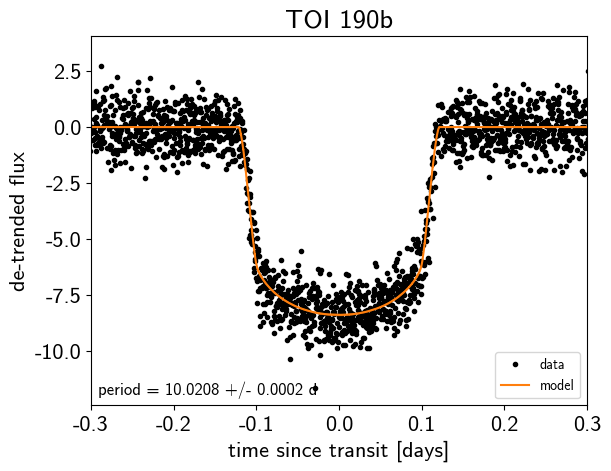

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

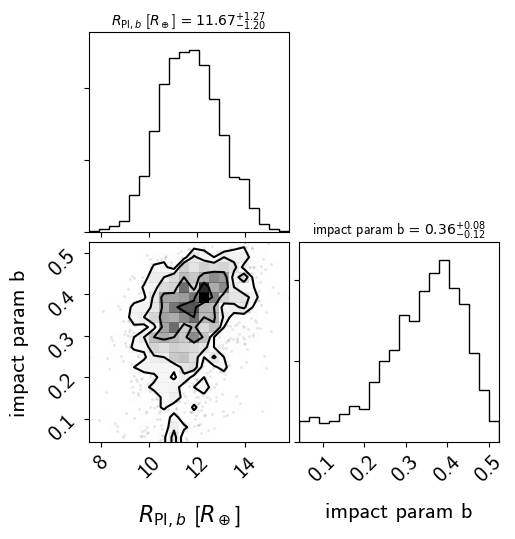

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

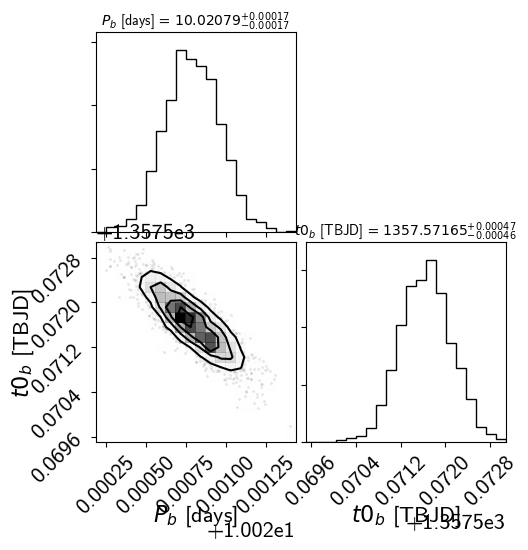

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

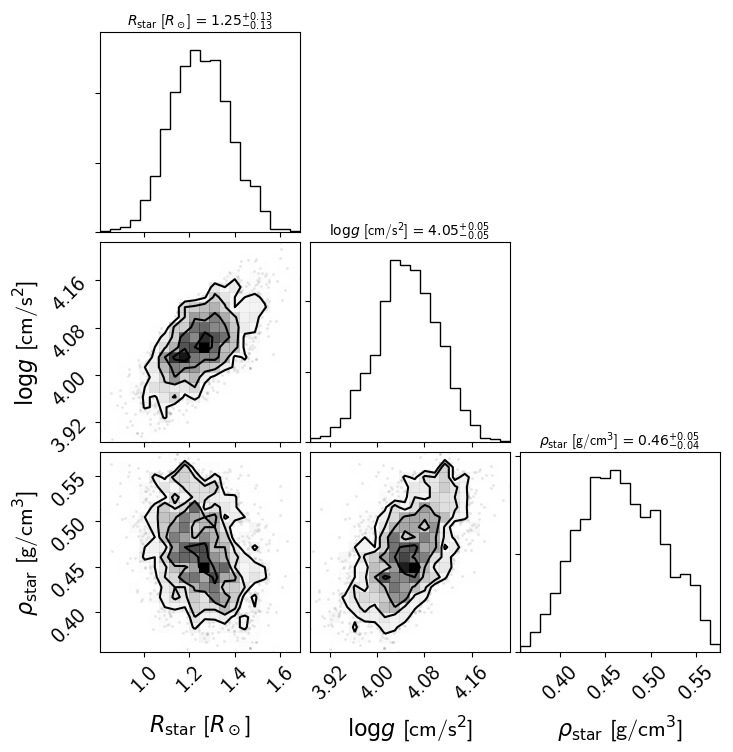

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3